In [1]:
import source_synphot.passband
import source_synphot.io
import source_synphot.source
import astropy.table as at
from collections import OrderedDict
import pysynphot as S
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
%matplotlib notebook

import sys
sys.path.append('../Sigma_clip/')
import sigmacut

#from zp_fit import *
from scipy.optimize import minimize
from astropy.stats import sigma_clip
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
def myround(x, prec=2, base=.5):
    return round(base * round(float(x)/base),prec)

In [2]:
models = at.Table.read('ckmodels.txt',format='ascii')
logZ = 0.
model_sed_names = []
temp = []
for s in models:
    teff = max(3500.,s['teff'])
    logg = myround(s['logg'])
    # the models with logg < 1 are just padded with 0s
    if logg >= 1:
        temp.append(teff)
        modstring = 'ckmod{:.0f}_{:.1f}_{:.2f}'.format(teff,logZ, logg)
        model_sed_names.append(modstring)
model_sed = source_synphot.source.load_source(model_sed_names)

In [3]:
passbands = at.Table.read('source_synphot/passbands/pbzptmag.txt',format='ascii')
pbnames = [x['obsmode'] for x in passbands if x['passband'].startswith("Kep")]
pbnames += [x['obsmode'] for x in passbands if x['passband'].startswith("PS1")]
model_mags = 0.
model = 'AB'
pbs = source_synphot.passband.load_pbs(pbnames, model_mags, model)
pbnames = pbs.keys()

21.405741755339733
0.0
20.836195000114955
0.0
21.370261319386927
0.0
21.793287528964058
0.0
22.09903034378283
0.0
22.325516493196154
0.0


In [4]:
color1 = 'ps1g_ps1r'
color2 = 'ps1r_ps1i'
col1 = []
col2 = []
col3 = []
col4 = []
col5 = []
# construct color-color vectors
pbg, zpg = pbs['ps1g']
pbr, zpr = pbs['ps1r']
pbi, zpi = pbs['ps1i']
pbz, zpz = pbs['ps1z']
for modelname in model_sed:
    model= model_sed[modelname]
    model = S.ArraySpectrum(model.wave, model.flux, name=modelname)
    c1, c2 = color1.split('_')
    pb1, zp1 = pbs[c1]
    pb2, zp2 = pbs[c2]
    c3, c4 = color2.split('_')
    c5 = 'Kep'
    pb3, zp3 = pbs[c3]
    pb4, zp4 = pbs[c4]
    pb5, zp5 = pbs[c5]
    thiscol1 = source_synphot.passband.syncolor(model, pbg, pbr, zpg, zpr)
    thiscol2 = source_synphot.passband.syncolor(model, pbg, pbi, zpg, zpi)
    thiscol3 = source_synphot.passband.syncolor(model, pbr, pbi, zpr, zpi)
    thiscol4 = source_synphot.passband.syncolor(model, pbi, pbz, zpi, zpz)
    #thiscol5 = source_synphot.passband.syncolor(model, pbg, pbi, zpg, zpi)
    col1.append(thiscol1)
    col2.append(thiscol2)
    col3.append(thiscol3)
    col4.append(thiscol4)
    #col5.append(thiscol5)
col1 = np.array(col1)
col2 = np.array(col2)
col3 = np.array(col3)
col4 = np.array(col4)
#col5 = np.array(col5)
# select only useful objects
good = ~np.isnan(col1)* ~np.isnan(col2)* ~np.isnan(col3)* ~np.isnan(col4)#* ~np.isnan(col5)
good = np.array(good)

-43.46142641608394 -42.98333592355688
-43.46142641608394 -42.60947897282194
-42.98333592355688 -42.60947897282194
-42.60947897282194 -42.30620538941916
-43.42811488150393 -42.951515875740036
-43.42811488150393 -42.57774416616112
-42.951515875740036 -42.57774416616112
-42.57774416616112 -42.27580812278789
-43.39254864242051 -42.91768135862316
-43.39254864242051 -42.543554018019584
-42.91768135862316 -42.543554018019584
-42.543554018019584 -42.24330276234709
-43.353785389445065 -42.880558352350945
-43.353785389445065 -42.505428421999966
-42.880558352350945 -42.505428421999966
-42.505428421999966 -42.206909080304385
-43.31022613671858 -42.83852207668186
-43.31022613671858 -42.46180740425197
-42.83852207668186 -42.46180740425197
-42.46180740425197 -42.16510897892403
-43.26048351414385 -42.79024698323816
-43.26048351414385 -42.411601056273696
-42.79024698323816 -42.411601056273696
-42.411601056273696 -42.11714984938075
-43.203775709942605 -42.73526336931801
-43.203775709942605 -42.354965136

In [605]:
data.keys()

Index(['ID', 'campaign', 'Kpmag', 'RAJ2000', 'DecJ2000', 'objID', 'ps_score',
       'raMean', 'decMean', 'raMeanErr', 'decMeanErr', 'qualityFlag',
       'gMeanPSFMag', 'gMeanPSFMagErr', 'gMeanPSFMagNpt', 'rMeanPSFMag',
       'rMeanPSFMagErr', 'rMeanPSFMagNpt', 'iMeanPSFMag', 'iMeanPSFMagErr',
       'iMeanPSFMagNpt', 'zMeanPSFMag', 'zMeanPSFMagErr', 'zMeanPSFMagNpt',
       'yMeanPSFMag', 'yMeanPSFMagErr', 'yMeanPSFMagNpt', 'rMeanKronMag',
       'rMeanKronMagErr', 'nDetections', 'ng', 'nr', 'ni', 'nz', 'ny',
       'gFlags', 'gQfPerfect', 'rFlags', 'rQfPerfect', 'iFlags', 'iQfPerfect',
       'zFlags', 'zQfPerfect', 'yFlags', 'yQfPerfect', 'primaryDetection',
       'bestDetection', 'Module', 'Channel', 'Output', 'PDC', 'PDCe', 'SAP',
       'SAPe'],
      dtype='object')

In [606]:
data = pd.read_csv('../calibration/kepler/K2_all_PS1_psc_ev.csv')
data = data.iloc[(data['ps_score'].values > 0.8) & (data['PDC'].values > 0)]
#cind =  ((data['campaign'].values == 16) & (data['Channel'].values == 70))
gb = data['gMeanPSFMag'].values - ex[0,:]
gbe = data['gMeanPSFMagErr'].values
rb = data['rMeanPSFMag'].values - ex[1,:]
rbe = data['rMeanPSFMagErr'].values
ib = data['iMeanPSFMag'].values - ex[2,:]
ibe = data['iMeanPSFMagErr'].values
zb = data['zMeanPSFMag'].values - ex[3,:]
zbe = data['zMeanPSFMagErr'].values
kb = -2.5*np.log10(data['PDC'].values)
kbe = np.abs(data['PDCe'].values) / np.abs(data['PDC'].values)

In [602]:

def Plotter(K,Colours,Compare,Channel,fitfilt, Residuals = False, Close = True):
    Params = Parms_dict(K)
    plt.figure()#figsize=(10,6))
    #plt.suptitle('Channel ' + str(Channel) + ', Zp = ' + str(np.round(K[0],3)) + 
     #            '\n' + 'Ak ={}, Ag = {}, Ar = {}, Ai ={}'.format(np.round(Params['Ak'],3),
     #                                                             np.round(Params['Ag'],3),
     #                                                             np.round(Params['Ar'],3),
     #                                                             np.round(Params['Ai'],3)))
    for i in range(len(Compare)):
        X,Y = Compare[i]
        keys = np.array(list(Colours.keys()))
        xind = 'mod ' + X == keys
        x = Colours[keys[xind][0]]
        yind = 'mod ' + Y == keys
        y = Colours[keys[yind][0]]

        x_interp = np.arange(np.nanmin(x),0.9,0.01)
        inter = interpolate.interp1d(x,y)
        l_interp = inter(x_interp)
        locus = np.array([x_interp,l_interp])
        ind  = np.where((locus[0,:] <= .9) & (locus[0,:] >= 0.2))[0]
        locus = locus[:,ind]
        # observed
        xind = 'obs ' + X == keys
        x = Colours[keys[xind][0]]
        yind = 'obs ' + Y == keys
        y = Colours[keys[yind][0]]
        #print(X,Y)
        c1,c2 = X.split('-')
        c3,c4 = Y.split('-')
        #print(c1,c2,c3,c4)

        # parameters
        ob_x = x.copy() 
        ob_x[0,:] += Params['A'+c1] - Params['A'+c2]
        if c1 == fitfilt: ob_x += Params['fitzp']
        if c2 == fitfilt: ob_x -= Params['fitzp']

        ob_y = y.copy() 
        ob_y[0,:] += Params['A'+c3] - Params['A'+c4]
        if c3 == fitfilt: ob_y[0,:] += Params['fitzp']
        if c4 == fitfilt: ob_y[0,:] -= Params['fitzp']

        ind = np.where((Colours['obs g-r'][0,:] <= .9) & (Colours['obs g-r'][0,:] >= 0.2))[0]
        ob_x = ob_x[:,ind]
        ob_y = ob_y[:,ind]
        
        
        #plt.subplot(2,2,i+1)
        plt.xlabel(X)
        plt.ylabel(Y)
        if i == 2:
            if Residuals:
                dist = Dist_tensor(X,Y,Params,Colours,fitfilt,Tensor = True)
                
                plt.errorbar(ob_x[0,:],dist,ob_y[1,:],fmt='.',alpha=0.4,label='Observed')
                plt.axhline(0,ls='--',color='k',label='Model')
                plt.legend(loc='upper center', bbox_to_anchor=(1.5, .5))
                plt.ylim(-.6, .6)
            else:
                plt.errorbar(ob_x[0,:],ob_y[0,:],ob_y[1,:],fmt='.',alpha=0.4,label='Observed')
                plt.plot(locus[0,:],locus[1,:],label='Model')
                plt.legend(loc='upper center', bbox_to_anchor=(1.5, .5))
                plt.xlim(0.2, .9)
                #plt.ylim(-.5, 1)
        else:
            if Residuals:
                dist = Dist_tensor(X,Y,Params,Colours,fitfilt,Tensor = True)
                plt.axhline(0,ls='--',color='k',label='offset = {}'.format(np.round(K[0],4)))
                plt.errorbar(ob_x[0,:],dist,ob_y[1,:],fmt='.',alpha=0.4)
                plt.legend()
                plt.ylabel(r'('+ Y +')obs - (' + Y + ')syn')
                #plt.hist(dist.flatten(),bins=100)
                #plt.ylim(-.6, .6)
            else:
                plt.errorbar(ob_x[0,:],ob_y[0,:],ob_y[1,:],fmt='.',alpha=0.4)
                plt.plot(locus[0,:],locus[1,:])
                #plt.xlim(-0.5, 1)
                plt.xlim(0.2, .9)
                #plt.ylim(-.5, 1)
    plt.subplots_adjust(wspace=.25,hspace=.2)
    if Residuals:
        plt.savefig('./figs/fit_i/'+ fitfilt + '_fit_' + Y + '_residual'+ '_camp' + str(Channel) +'.png')
    else:
        plt.savefig('./figs/fit_i/'+ fitfilt + Y + '_camp' + str(Channel) + '.png')
    if Close:
        plt.close()
    
def Dot_prod_error(x,y,Model):
    """
    Calculate the error projection in the direction of a selected point.
    """
    #print(Model.shape)
    adj = y[0,:] - Model[1,:]
    op = x[0,:] - Model[0,:]
    #print(adj.shape,op.shape)
    hyp = np.sqrt(adj**2 + op**2)
    costheta = adj / hyp
    yerr_proj = abs(y[1,:] * costheta)
    xerr_proj = abs(x[1,:] * costheta)
    
    proj_err = yerr_proj + xerr_proj
    #print(proj_err)
    return proj_err    

def Calculate_distance(data,trend):
    x = np.zeros((data.shape[1],trend.shape[1])) + data[0,:,np.newaxis]
    x -= trend[0,np.newaxis,:]
    y = np.zeros((data.shape[1],trend.shape[1])) + data[1,:,np.newaxis]
    y -= trend[1,np.newaxis,:]

    dist = np.sqrt(x**2 + y**2)

    minind = np.nanargmin(abs(dist),axis=1)
    #proj_err = Dot_prod_error(ob_x,ob_y,locus[:,minind])
    mindist = np.nanmin(abs(dist),axis=1)
    sign = (data[1,:] - trend[1,minind])
    sign = sign / abs(sign)

    resid = mindist * sign
    return resid

def Dist_tensor(X,Y,Params,Colours,fitfilt,Tensor=False,Plot = False):
    keys = np.array(list(Colours.keys()))
    xind = 'mod ' + X == keys
    x = Colours[keys[xind][0]]
    yind = 'mod ' + Y == keys
    y = Colours[keys[yind][0]]
    
    x_interp = np.arange(np.nanmin(x),0.9,0.01)
    inter = interpolate.interp1d(x,y)
    l_interp = inter(x_interp)
    locus = np.array([x_interp,l_interp])
    # observed
    xind = 'obs ' + X == keys
    x = Colours[keys[xind][0]]
    yind = 'obs ' + Y == keys
    y = Colours[keys[yind][0]]
    #print(X,Y)
    c1,c2 = X.split('-')
    c3,c4 = Y.split('-')
    #print(c1,c2,c3,c4)
    

    # parameters
    ob_x = x.copy() 
    ob_y = y.copy() 
    indo = np.where((Colours['obs g-r'][0,:] <= .9) & (Colours['obs g-r'][0,:] >= 0.2))
    
    ob_x[0,:] += Params['A'+c1] - Params['A'+c2]
    if c1 == fitfilt: ob_x[0,:] += Params['fitzp']
    if c2 == fitfilt: ob_x[0,:] -= Params['fitzp']

    
    ob_y[0,:] += Params['A'+c3] - Params['A'+c4]
    if c3 == fitfilt: ob_y[0,:] += Params['fitzp']
    if c4 == fitfilt: ob_y[0,:] -= Params['fitzp']
    
    ind = np.where((Colours['obs g-r'][0,:] <= .9) & (Colours['obs g-r'][0,:] >= 0.2))[0]
    ob_x = ob_x[:,ind]
    ob_y = ob_y[:,ind]
    
    
    if Plot:
        plt.figure()
        plt.title(X + ' ' + Y)
        plt.plot(ob_x[0,:],ob_y[0,:],'.')
        plt.plot(locus[0,:],locus[1,:])
    #print(ob_x.shape)
    #print('x ',ob_x.shape[1])
    x = np.zeros((ob_x.shape[1],locus.shape[1])) + ob_x[0,:,np.newaxis]
    x -= locus[0,np.newaxis,:]
    y = np.zeros((ob_y.shape[1],locus.shape[1])) + ob_y[0,:,np.newaxis]
    y -= locus[1,np.newaxis,:]

    dist_tensor = np.sqrt(x**2 + y**2)
    #print(np.nanmin(dist_tensor,axis=1))
    #print(X + Y +' dist ',dist_tensor.shape)
    if len(dist_tensor) > 0:
        minind = np.nanargmin(abs(dist_tensor),axis=1)
        mindist = np.nanmin(abs(dist_tensor),axis=1)
        sign = (ob_y[0,:] - locus[1,minind])
        sign = sign / abs(sign)

        eh = mindist * sign
    
        proj_err = Dot_prod_error(ob_x,ob_y,locus[:,minind])
        #print('mindist ',mindist)
        if Tensor:
            return eh
        if len(mindist) > 0:
            #print('thingo',np.nanstd(mindist))
            residual = np.nansum(abs(mindist)) #/ proj_err)
        else:
            #print('infs')
            residual = np.inf
    else:
        if Tensor:
            return []
        residual = np.inf
        #residual += 100*np.sum(np.isnan(dist))
    #print(residual)
    cut_points = len(indo) - len(ind)
    return residual + cut_points * 100



import copy
def Get_lcs(X,Y,Params,Colours,fitfilt):
    keys = np.array(list(Colours.keys()))

    xind = 'mod ' + X == keys
    x = Colours[keys[xind][0]]
    yind = 'mod ' + Y == keys
    y = Colours[keys[yind][0]]

    x_interp = np.arange(np.nanmin(x),0.9,0.01)
    inter = interpolate.interp1d(x,y)
    l_interp = inter(x_interp)
    locus = np.array([x_interp,l_interp])

    xind = 'obs ' + X == keys
    x = Colours[keys[xind][0]]
    yind = 'obs ' + Y == keys
    y = Colours[keys[yind][0]]
    c1,c2 = X.split('-')
    c3,c4 = Y.split('-')
    # parameters
    ob_x = x.copy() 
    ob_y = y.copy() 

    ob_x[0,:] += Params['A'+c1] - Params['A'+c2]
    if c1 == fitfilt: ob_x[0,:] += Params['fitzp']
    if c2 == fitfilt: ob_x[0,:] -= Params['fitzp']


    ob_y[0,:] += Params['A'+c3] - Params['A'+c4]
    if c3 == fitfilt: ob_y[0,:] += Params['fitzp']
    if c4 == fitfilt: ob_y[0,:] -= Params['fitzp']
    return ob_x, ob_y, locus

def sigma_mask(data,error= None,sigma=3,Verbose= False):
    if type(error) == type(None):
        error = np.zeros(len(data))
    
    calcaverage = sigmacut.calcaverageclass()
    calcaverage.calcaverage_sigmacutloop(data,verbose=2,Nsigma=sigma
                                         ,median_firstiteration=True,saveused=True)
    #if Verbose:
    print("mean:%f (uncertainty:%f)" % (calcaverage.mean,calcaverage.mean_err))
    return calcaverage.clipped


def Cut_data(K,Colours,Compare,fitfilt,Plot=False):
    Params = Parms_dict(K)
    c_cut = copy.deepcopy(Colours)
    for X,Y in Compare:
        #X = 'g-r'
        #Y = 'i-z'
        dist = Dist_tensor(X,Y,Params,Colours,fitfilt,True)
        if len(dist) > 0:

            ob_x, ob_y, locus = Get_lcs(X,Y,Params,Colours,fitfilt)
            ob_x2, ob_y2, locus = Get_lcs(X,Y,Params,Colours,fitfilt)
            ind = np.where((Colours['obs g-r'][0,:] <= .9) & (Colours['obs g-r'][0,:] >= 0.2))[0]

            #if X == 'g-r':
            #    ind = np.where((ob_x[0,:] <= .9) & (ob_x[0,:] >= 0.2) & (ob_y[1,:] < 0.5))[0]
            #elif X == 'r-i':
            #    ind = np.where((ob_x[0,:] <= .6) & (ob_x[0,:] >= 0) & (ob_y[1,:] < 0.5))[0]
            ob_x = ob_x[:,ind]
            ob_y = ob_y[:,ind]


            #bad = []
            #print(type(dist))
            #print('std',np.nanstd(dist.flatten()))
            dist = dist.flatten()
            finiteinds = np.where(np.isfinite(dist))[0]
            #dist[~np.isfinite(dist)] = np.nan
            bad = sigma_mask(dist,error=ob_y[:,1],sigma=3)
            bad = finiteinds[bad]
            #for i in range(len(dist)):
                #print(dist[i],ob_y[1,i])
             #   if abs(dist[i]) > 1:
                    #print(dist,ob_y[0,i])
              #      bad += [i]
              #  if abs(dist[i]) > 10*ob_y[1,i]:

               #     bad += [i]
            if Plot:
                plt.figure()
                plt.errorbar(ob_x2[0,:],ob_y2[0,:],yerr = ob_y2[1,:],fmt='.')
                plt.errorbar(locus[0,:],locus[1,:])
                #plt.errorbar(ob_x[0,bad],ob_y[0,bad],yerr = ob_y[1,bad],fmt='.')
                plt.errorbar(ob_x2[0,ind[bad]],ob_y2[0,ind[bad]],yerr = ob_y2[1,ind[bad]],fmt='r.')
                #plt.xlim(.5,0.9)

            for key in keys:
                if 'obs' in key:
                    #print(dist[bad],6*c_cut[key][1, main_ind[bad]])
                    c_cut[key][:, ind[bad]] = np.nan
                    #print('killed ', key)
            #print(colours[keys[xind][0]][:, main_ind[bad]])
    return c_cut

def Parms_dict(K):
    num = len(K)
    
    k =np.zeros(6)
    if num ==1:
        k[0] = K[0]
        k[1:] = 0
    else:
        k = K
    Params = {}
    Params['fitzp'] = k[0]
    Params['Ak'] = k[1]
    Params['Ag'] = k[2]
    Params['Ar'] = k[3]
    Params['Ai'] = k[4]
    Params['Az'] = k[4]
    
    return Params

def SLR_fit_multi(K,Colours,Compare,fitfilt,Second=False):
    
    params = Parms_dict(K)
    res = 0
    #print(K)
    for x,y in Compare:
        residual = Dist_tensor(x,y,params,Colours,fitfilt,Tensor=True)
        if len(residual)>0:
            res += np.nansum(abs(residual))
        else:
            res = np.inf
    #print('residual ', res)
    return res
    

      fun: inf
 hess_inv: array([[1]])
      jac: array([nan])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.])
[ 0.02074809  0.02920768  0.55803785 ... -0.00903327  0.04006168
 -0.01643008]
i:00 mean:0.020316(0.001387) stdev:0.055935(0.000981) Nchanged:0 Nused:1626 Nskipped:0
i:01 mean:0.020654(0.000542) stdev:0.021779(0.000384) Nchanged:14 Nused:1612 Nskipped:14
i:02 mean:0.020121(0.000460) stdev:0.018367(0.000325) Nchanged:20 Nused:1592 Nskipped:34
i:03 mean:0.020165(0.000441) stdev:0.017528(0.000312) Nchanged:15 Nused:1577 Nskipped:49
i:04 mean:0.020200(0.000440) stdev:0.017479(0.000311) Nchanged:1 Nused:1576 Nskipped:50
i:05 mean:0.020200(0.000440) stdev:0.017479(0.000311) Nchanged:0 Nused:1576 Nskipped:50
mean:0.020200 (uncertainty:0.000440)


<IPython.core.display.Javascript object>


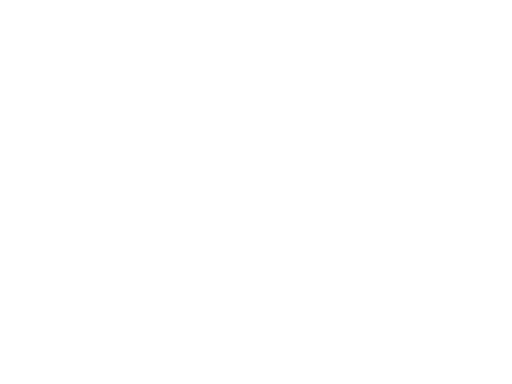

<IPython.core.display.Javascript object>


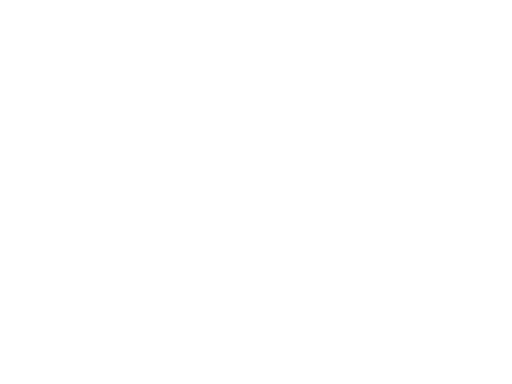

      fun: 32.82319136323881
 hess_inv: array([[1.62711918e-05]])
      jac: array([4.76837158e-07])
  message: 'Optimization terminated successfully.'
     nfev: 27
      nit: 6
     njev: 9
   status: 0
  success: True
        x: array([0.03436849])
[ 0.00559437  0.01302171  0.55384495 ... -0.02247909  0.030402
 -0.05794129]
i:00 mean:0.001082(0.002020) stdev:0.081443(0.001428) Nchanged:0 Nused:1626 Nskipped:0
i:01 mean:0.001279(0.000753) stdev:0.030199(0.000532) Nchanged:16 Nused:1610 Nskipped:16
i:02 mean:0.000895(0.000660) stdev:0.026310(0.000466) Nchanged:19 Nused:1591 Nskipped:35
i:03 mean:0.000787(0.000648) stdev:0.025798(0.000458) Nchanged:6 Nused:1585 Nskipped:41
i:04 mean:0.000787(0.000648) stdev:0.025798(0.000458) Nchanged:0 Nused:1585 Nskipped:41
mean:0.000787 (uncertainty:0.000648)


<IPython.core.display.Javascript object>


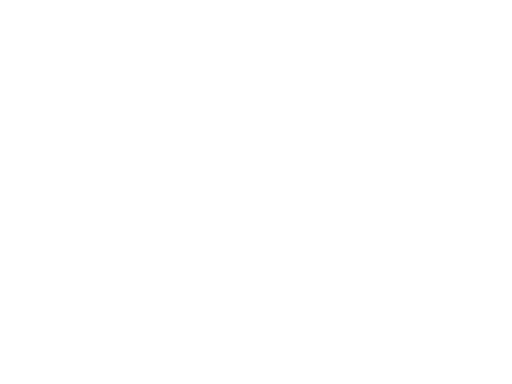

<IPython.core.display.Javascript object>


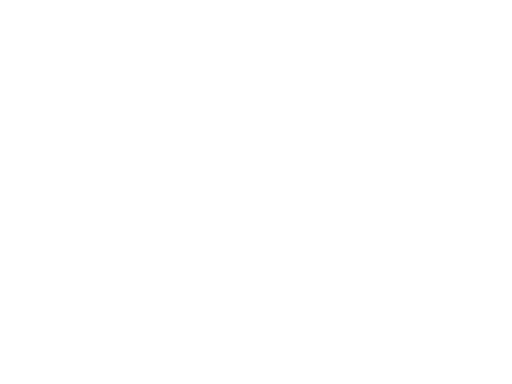

      fun: 33.683006859438876
 hess_inv: array([[1.6886223e-05]])
      jac: array([0.00040674])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 270
      nit: 6
     njev: 86
   status: 2
  success: False
        x: array([-0.00977108])
[ 0.01295545  0.00445107  0.21694696 ... -0.01213662  0.02893825
  0.00594934]
i:00 mean:0.001717(0.002517) stdev:0.101493(0.001780) Nchanged:0 Nused:1626 Nskipped:0
i:01 mean:0.000242(0.000678) stdev:0.027195(0.000480) Nchanged:18 Nused:1608 Nskipped:18
i:02 mean:0.000074(0.000538) stdev:0.021428(0.000380) Nchanged:21 Nused:1587 Nskipped:39
i:03 mean:-0.000019(0.000531) stdev:0.021138(0.000376) Nchanged:4 Nused:1583 Nskipped:43
i:04 mean:-0.000100(0.000526) stdev:0.020920(0.000372) Nchanged:4 Nused:1579 Nskipped:47
i:05 mean:-0.000100(0.000526) stdev:0.020920(0.000372) Nchanged:0 Nused:1579 Nskipped:47
mean:-0.000100 (uncertainty:0.000526)


<IPython.core.display.Javascript object>


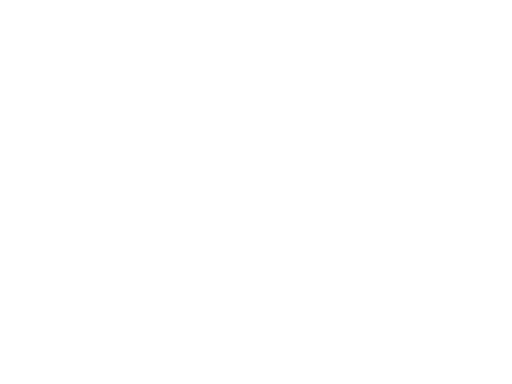

<IPython.core.display.Javascript object>


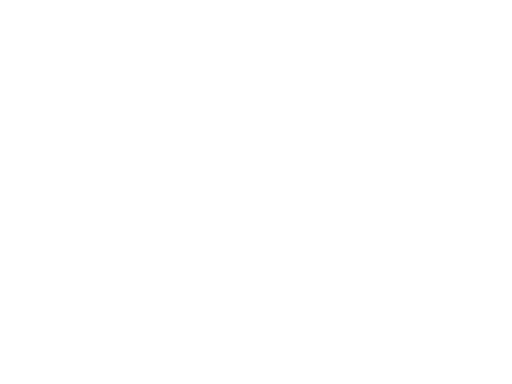

      fun: 23.76861651353611
 hess_inv: array([[1.03673647e-05]])
      jac: array([0.00074339])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 175
      nit: 6
     njev: 55
   status: 2
  success: False
        x: array([0.03617956])
[ 3.96315294e-03  5.07184292e-01 -7.01136486e-03 -1.42920559e-02
  2.39066593e-02  8.86779320e-03  2.14556258e-02  2.16718117e-02
  1.10900133e-02 -1.87168633e-02  1.46593682e-02 -7.83534448e-03
 -6.15256276e-02  5.24770040e-03  1.33301226e-02  7.84301323e-01
  1.41039289e-02 -5.51000864e-03  4.35229889e-01 -1.74510579e-02
 -7.21183352e-03 -8.46601577e-03  5.78411752e-03 -7.21715163e-03
 -1.21070139e-02 -2.26816074e-02  1.09877472e-02 -3.16732756e-01
 -2.03693593e-02 -2.28567759e-02 -1.90390269e-02 -5.28801183e-02
 -1.67011901e-02  1.26484713e-02 -2.95736377e-02 -3.26535295e-02
 -4.63169908e-02 -2.15596616e-02  1.46799834e-02 -8.91782152e-03
  1.11425580e-02  1.39138480e-02  6.69329296e-03 -1.21917775e-02
  1.171395

<IPython.core.display.Javascript object>


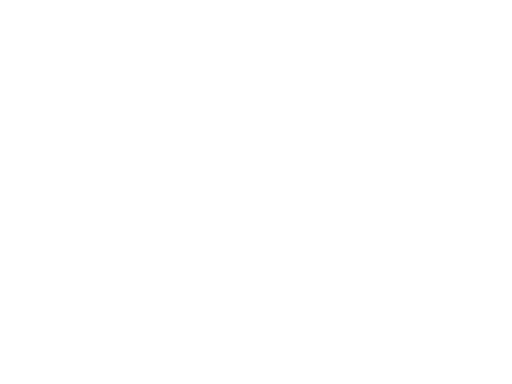

<IPython.core.display.Javascript object>


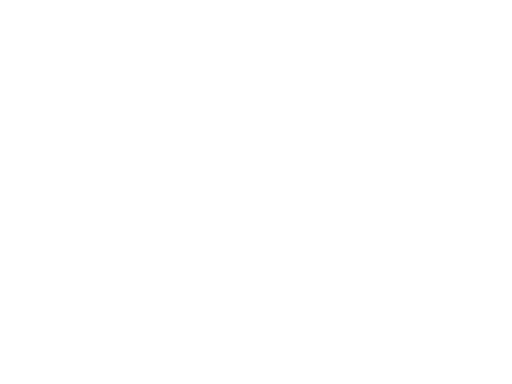

      fun: 2.376452632070196
 hess_inv: array([[0.00035319]])
      jac: array([8.94069672e-08])
  message: 'Optimization terminated successfully.'
     nfev: 27
      nit: 6
     njev: 9
   status: 0
  success: True
        x: array([0.01986572])
[ 2.04650915e-02  5.58852144e-01  2.28977919e-02 -4.53144755e-03
  5.14828013e-02  2.95321345e-02  3.91093075e-02  4.90088747e-02
  2.12825766e-03 -1.16856671e-02  3.16822682e-02  4.05388395e-03
 -8.13724196e-02  1.04907164e-02  3.60438394e-02  9.39323598e-01
 -9.15749148e-03  5.99337248e-03  6.23287515e-01 -1.23228292e-02
  5.08880122e-03  6.85184980e-03  1.36343492e-02  1.07367268e-02
 -4.21571497e-03 -2.22852343e-02 -1.06666124e-03 -4.94255967e-01
 -1.45014831e-02 -2.08581849e-02 -1.56036940e-02 -6.72473689e-02
 -3.04979408e-03  3.38521889e-02 -3.20249886e-02 -3.67574196e-02
 -5.76164389e-02 -1.80998948e-02 -5.97393183e-03  2.84154364e-03
  2.69384140e-02  3.37254326e-02  2.48904659e-02 -3.63370816e-03
  3.31579686e-02 -2.28699069e-02  4.7

<IPython.core.display.Javascript object>


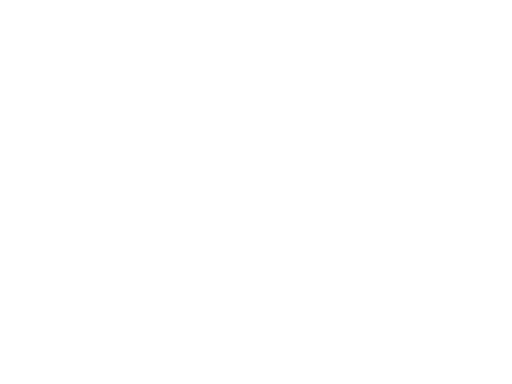

<IPython.core.display.Javascript object>


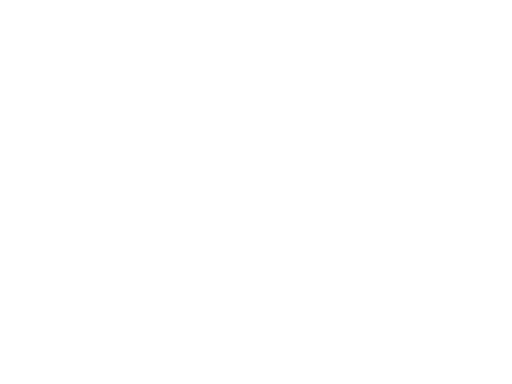

      fun: 2.0886385839246295
 hess_inv: array([[0.00037008]])
      jac: array([1.95503235e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 67
      nit: 8
     njev: 22
   status: 2
  success: False
        x: array([-0.03725241])
[ 1.76432996e-02  1.35386897e-01 -1.42618337e-02  1.27839494e-02
  2.03800635e-02  1.67963735e-02  5.44988474e-03  1.96333562e-02
  3.59183113e-02 -1.68390861e-02  1.46419987e-02  4.45929789e-03
  1.34381412e-01  3.44193559e-02  2.62492304e-02  3.65262754e-01
 -2.74120672e-02  1.00027131e-02  1.84016308e-01  7.47932205e-03
 -8.97562549e-03 -3.68963839e-02  3.57792788e-02 -1.28632307e-02
  1.09702495e-02 -1.59396346e-02  1.08675583e-03  4.97587475e-01
  6.92840307e-04 -1.60325362e-02 -1.62852293e-02  7.03967410e-02
  3.28863591e-03  2.58256108e-02 -8.44760876e-03 -2.02289078e-02
  1.13097445e-01  1.57956948e-02  8.17062278e-03  2.59205308e-02
  1.83589438e-02  6.69374229e-03  1.55080089e-02  2.49693227e-02
  1.05234

<IPython.core.display.Javascript object>


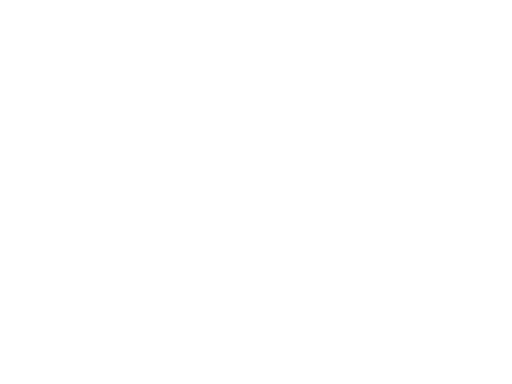

<IPython.core.display.Javascript object>


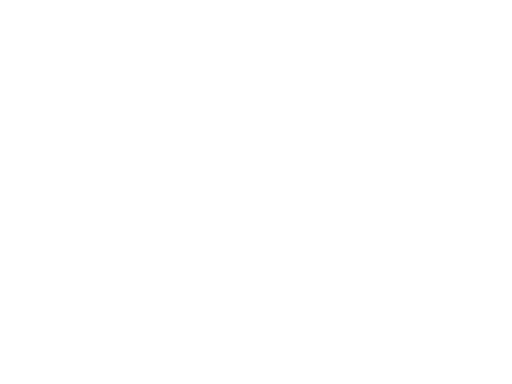

      fun: 2.0024838553320015
 hess_inv: array([[0.00014553]])
      jac: array([4.92334366e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 210
      nit: 6
     njev: 66
   status: 2
  success: False
        x: array([0.02098257])
[-2.42159830e-02 -1.46988427e-02 -3.36026908e-02  2.06325029e-02
  5.66812646e-02  3.27856820e-02 -6.42072082e-03 -1.78069581e-01
 -3.02566657e-03 -3.56364762e-03  1.14397250e-02 -2.65133797e-02
  3.11808513e-02 -1.43208409e-02  1.81932040e-02  1.34774670e-02
  7.01348868e-03 -1.17243681e-02  5.80928224e-03 -1.71407792e-01
 -6.12902740e-03 -7.13858669e-03 -8.56461771e-03  1.11596636e-02
 -1.19539159e-02  6.13836567e-02  2.09159055e-02  6.27760562e-02
 -4.10611762e-03  3.84813234e-02  8.84184386e-02  1.66533353e-02
  3.28971402e-02 -4.02223132e-03 -9.35112620e-02  1.25787380e-02
  4.52475121e-02 -7.66232408e-03  1.31577578e-02 -4.70659260e-02
 -1.28438932e-02  3.71144031e-03  3.86209161e-01 -1.84346242e-02
  2.37284

<IPython.core.display.Javascript object>


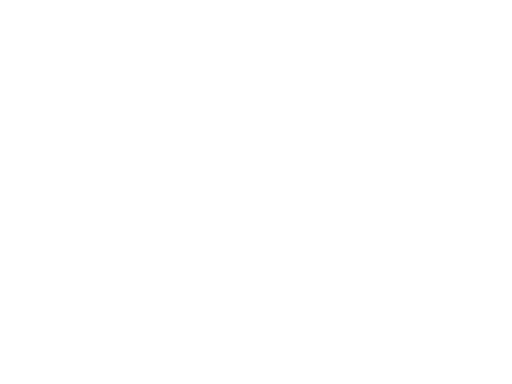

<IPython.core.display.Javascript object>


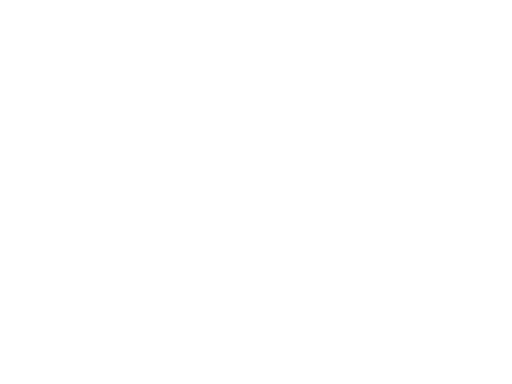

      fun: 15.972347688922774
 hess_inv: array([[3.02736911e-05]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([0.02069487])
[-3.71320000e-02 -1.76663315e-02 -5.33833612e-02  3.17591409e-02
  8.49326663e-02  4.68644620e-02 -9.04769320e-03 -2.86909857e-01
 -4.19367112e-03 -5.51908825e-03 -1.16495323e-02 -4.02241722e-02
  4.99592556e-02 -1.90595020e-02  2.94870521e-02  2.19732133e-02
  1.14842162e-02 -1.74960783e-02  3.74150396e-03 -2.75078929e-01
 -5.73212222e-03 -4.73234770e-03 -5.77122307e-03  1.38431313e-02
 -1.90972882e-02  9.13034688e-02  3.20544891e-02  1.01812753e-01
 -6.37890166e-03  6.03255107e-02  1.03275047e-01  2.70171001e-02
  4.73543466e-02 -5.23519208e-03 -1.49678968e-01  1.81598486e-02
  6.38722869e-02  6.65004729e-03  1.68659358e-02 -7.29952468e-02
 -1.76715349e-02  6.18791597e-03  4.12053314e-01 -2.57981984e-02
  3.43850966e-02  1.35733767e-02  6.44939906

<IPython.core.display.Javascript object>


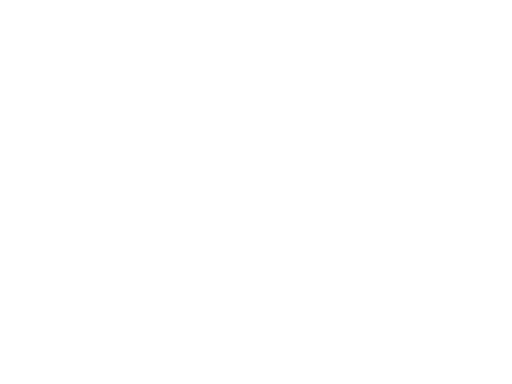

<IPython.core.display.Javascript object>


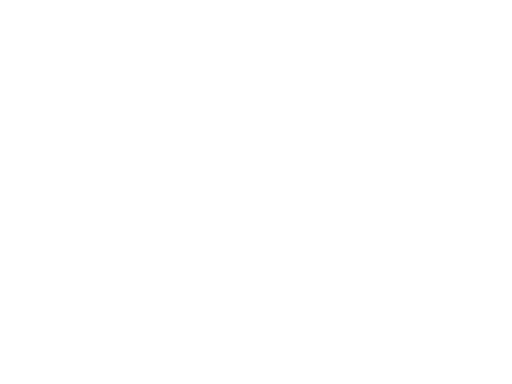

      fun: 18.62054348870518
 hess_inv: array([[2.23667187e-05]])
      jac: array([-9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([-0.01713814])
[-7.70630208e-03 -5.53824355e-02 -1.78264081e-02  3.01587603e-02
  1.54552677e-02 -7.93280625e-03  1.41162919e-02  2.99598135e-01
 -1.07696265e-02 -3.18318661e-03 -9.43568021e-03 -2.22754702e-02
 -1.00797908e-02  1.19112739e-01  9.06033923e-03  1.15867954e-02
  1.90871544e-02  7.79425672e-03 -2.51444532e-02  2.83402482e-02
 -2.47185627e-02  7.13600126e-02  5.84558423e-02  6.65857472e-03
 -4.98110758e-02  3.84953037e-02  1.39335458e-02  3.76789203e-03
  4.67928075e-02  1.59193651e-02  9.41740617e-02  1.53620901e-02
  1.74137339e-02  2.45302774e-03  1.45918543e-01 -3.39067903e-02
 -5.88110621e-03 -1.29430521e-02  9.05592755e-03  7.76853833e-02
  2.24569341e-02 -4.46159863e-03  1.79231134e-01  1.12624184e-02
 -6.93553146e-03 -1.17904662e-0

<IPython.core.display.Javascript object>


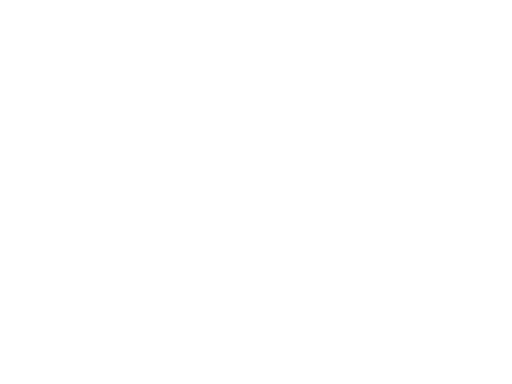

<IPython.core.display.Javascript object>


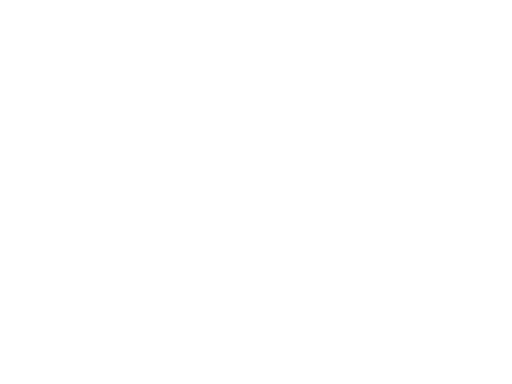

      fun: 11.769399961447828
 hess_inv: array([[1.76192332e-05]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 5
     njev: 10
   status: 0
  success: True
        x: array([0.02261071])
[ 1.03151074e-02 -5.07239719e-03  1.81502309e-02 -6.42997235e-03
 -8.33438159e-03 -2.13791392e-03  4.54553691e-01  1.66845124e-02
  8.83607971e-03  4.39530781e-03 -1.61201923e-03  1.65862477e-02
 -7.39782548e-03 -3.78430165e-02 -2.68447322e-02 -6.09217301e-03
  8.06034402e-01 -3.17981632e-02  7.10600939e-01  4.42678380e-02
 -4.52769967e-03  1.12463301e-01  8.36801999e-03  3.58451059e-01
  2.34743714e-01  1.06777856e-02 -7.66446798e-03 -1.76658609e-02
  6.70775441e-01  1.10221545e-02  6.60644461e-01 -5.63311706e-03
 -9.55377568e-03 -5.27004239e-03  1.37412962e-02 -2.88444025e-02
  1.05760345e-02  1.14618299e-02 -8.21845286e-03  6.43859246e-01
  2.91047154e-02  2.94868596e-02 -1.45845908e-02  3.03386531e-03
  2.39151868e-02 -5.94489431e-03  1.4437803

<IPython.core.display.Javascript object>


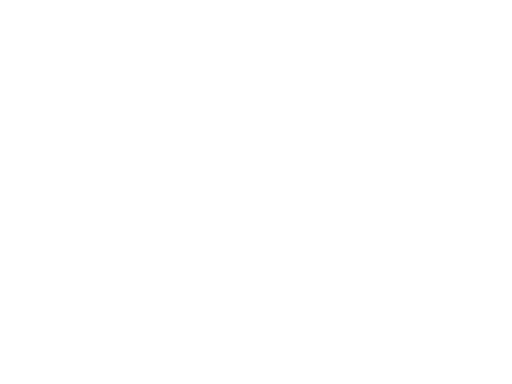

<IPython.core.display.Javascript object>


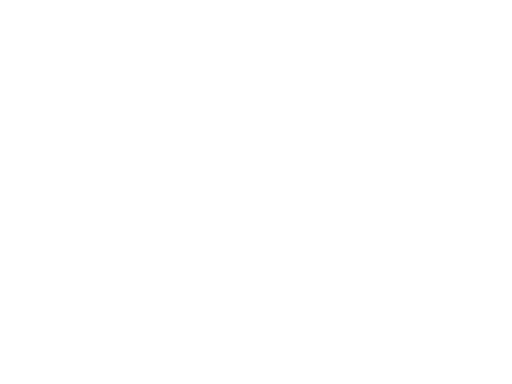

      fun: 16.890480896778172
 hess_inv: array([[3.7447738e-05]])
      jac: array([-2.38418579e-07])
  message: 'Optimization terminated successfully.'
     nfev: 27
      nit: 6
     njev: 9
   status: 0
  success: True
        x: array([0.02891945])
[ 1.05622917e-02 -8.97767548e-03  2.25864653e-02 -1.18214796e-02
 -1.91516118e-02 -8.59339805e-03  4.64558256e-01  1.00372826e-02
 -7.13254812e-03 -4.61041907e-03 -7.53023203e-03  1.97925607e-02
 -1.64427334e-02 -6.65624792e-02 -4.88404027e-02 -1.50436323e-02
  8.14424229e-01 -5.60914521e-02  7.23897319e-01  6.53895961e-02
 -1.28685874e-02  1.75767738e-01 -1.06542542e-02  3.52391879e-01
  3.16220426e-01 -1.76336106e-02  4.34567106e-03 -3.28701557e-02
  6.57647373e-01  9.98381834e-03  6.67603757e-01 -1.41670182e-02
 -2.06160011e-02 -1.33283052e-02  1.29851385e-02 -5.21406233e-02
  7.86730789e-03  1.06626772e-02 -5.82770703e-03  6.30590128e-01
  3.97353659e-02  4.12064649e-02 -2.62606779e-02 -6.37441883e-03
  2.95184845e-02 -1.53844435e-02

<IPython.core.display.Javascript object>


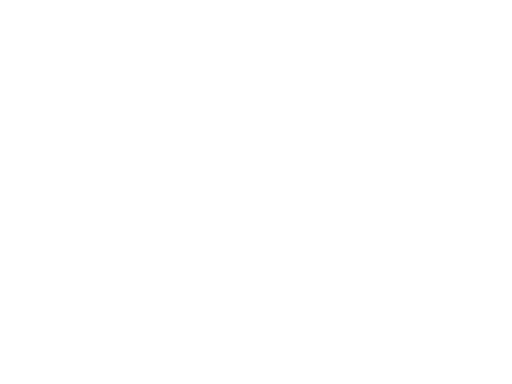

<IPython.core.display.Javascript object>


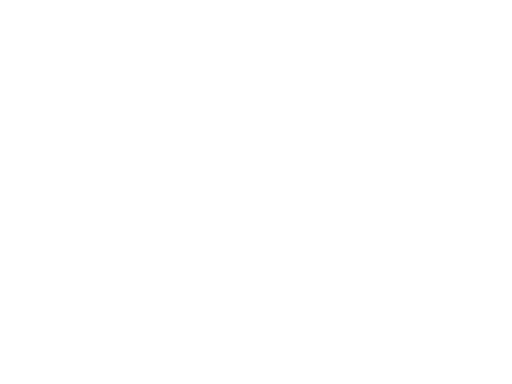

      fun: 13.878408961422585
 hess_inv: array([[1.96468011e-05]])
      jac: array([2.38418579e-07])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 7
     njev: 10
   status: 0
  success: True
        x: array([-0.01898013])
[ 8.06560184e-03 -1.40890706e-02  3.13670514e-02 -1.44647674e-02
 -1.89230750e-02  8.22611119e-03  1.48131799e-01 -1.37535452e-02
  1.10590968e-02 -2.52148072e-02 -1.33716761e-02 -8.13421572e-04
 -3.12834088e-02 -2.17594582e-02 -1.10574303e-02 -4.15220260e-03
  3.17410513e-01  1.42647722e-02  2.75349709e-01  3.96543129e-02
  9.15647067e-03  1.80068595e-01 -1.31954528e-02  1.61669802e-01
  3.30794472e-01  1.69348987e-03  2.44356901e-02 -1.53218566e-02
  2.26912873e-01 -1.97466476e-02  2.54676463e-01 -3.22414741e-02
 -3.60383397e-02  2.30596474e-02 -4.52958352e-03 -2.59398292e-02
 -9.15950309e-03  1.72724179e-03  1.53013293e-02  2.24098553e-01
  3.10705523e-02 -7.95368825e-02 -1.48263784e-02 -2.10390677e-02
  7.99300004e-03 -2.77676847e-

<IPython.core.display.Javascript object>


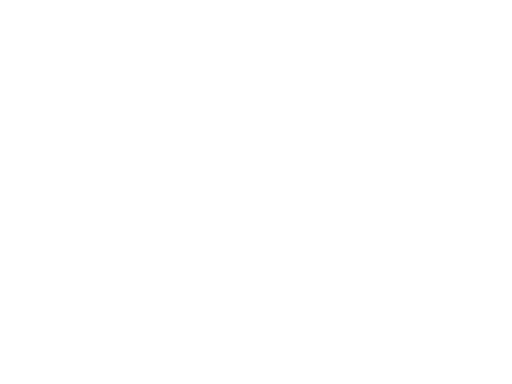

<IPython.core.display.Javascript object>


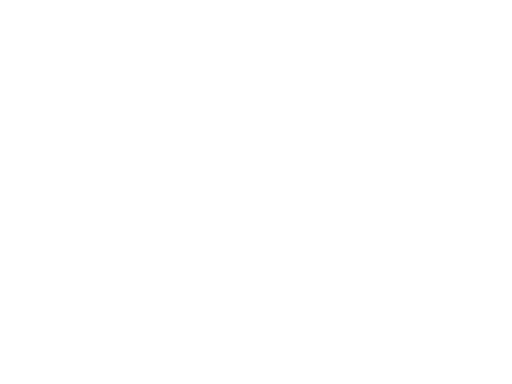

      fun: 14.378758072711456
 hess_inv: array([[2.11491515e-05]])
      jac: array([0.00010407])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 134
      nit: 6
     njev: 41
   status: 2
  success: False
        x: array([0.02974546])
[-0.01278597 -0.00959882 -0.01912878 ... -0.00820754 -0.00789053
 -0.00934881]
i:00 mean:-0.001924(0.001126) stdev:0.081958(0.000796) Nchanged:0 Nused:5296 Nskipped:0
i:01 mean:-0.000403(0.000336) stdev:0.024327(0.000237) Nchanged:40 Nused:5256 Nskipped:40
i:02 mean:0.000080(0.000239) stdev:0.017205(0.000169) Nchanged:82 Nused:5174 Nskipped:122
i:03 mean:-0.000139(0.000224) stdev:0.016035(0.000159) Nchanged:60 Nused:5114 Nskipped:182
i:04 mean:-0.000228(0.000221) stdev:0.015742(0.000156) Nchanged:21 Nused:5093 Nskipped:203
i:05 mean:-0.000228(0.000220) stdev:0.015691(0.000156) Nchanged:4 Nused:5089 Nskipped:207
i:06 mean:-0.000218(0.000220) stdev:0.015678(0.000155) Nchanged:1 Nused:5088 Nskipped:208
i:07 mean:-0.00

<IPython.core.display.Javascript object>


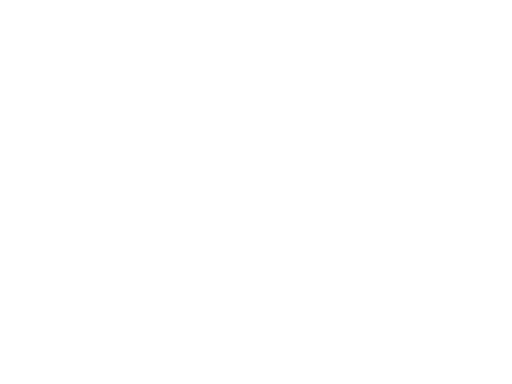

<IPython.core.display.Javascript object>


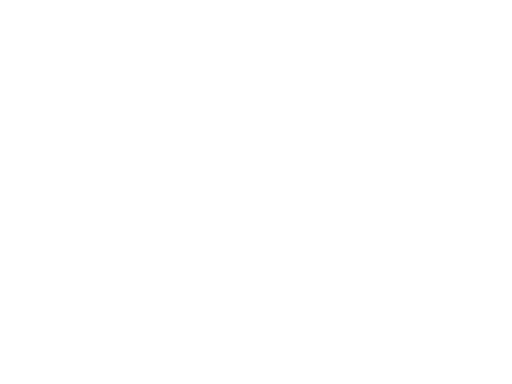

      fun: 96.66930563894674
 hess_inv: array([[4.99894446e-06]])
      jac: array([-2.86102295e-06])
  message: 'Optimization terminated successfully.'
     nfev: 27
      nit: 6
     njev: 9
   status: 0
  success: True
        x: array([0.02836856])
[-0.01608033 -0.0105068  -0.02901924 ...  0.01001815  0.00570382
 -0.00854377]
i:00 mean:0.000952(0.001440) stdev:0.104811(0.001018) Nchanged:0 Nused:5296 Nskipped:0
i:01 mean:0.000503(0.000476) stdev:0.034488(0.000337) Nchanged:50 Nused:5246 Nskipped:50
i:02 mean:0.000948(0.000355) stdev:0.025480(0.000251) Nchanged:84 Nused:5162 Nskipped:134
i:03 mean:0.000717(0.000333) stdev:0.023807(0.000236) Nchanged:59 Nused:5103 Nskipped:193
i:04 mean:0.000701(0.000329) stdev:0.023494(0.000233) Nchanged:15 Nused:5088 Nskipped:208
i:05 mean:0.000687(0.000329) stdev:0.023438(0.000232) Nchanged:3 Nused:5085 Nskipped:211
i:06 mean:0.000659(0.000328) stdev:0.023401(0.000232) Nchanged:2 Nused:5083 Nskipped:213
i:07 mean:0.000659(0.000328) stdev:0.023401(

<IPython.core.display.Javascript object>


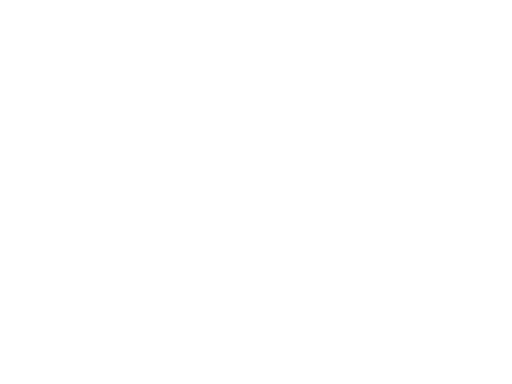

<IPython.core.display.Javascript object>


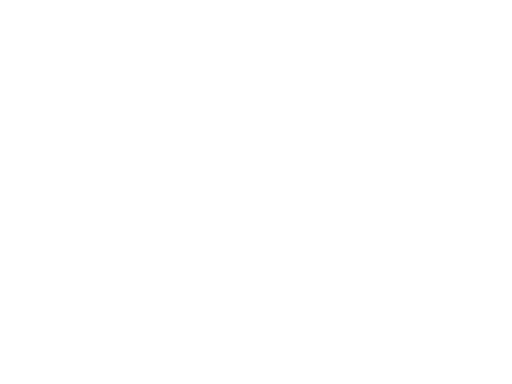

      fun: 85.75291731720758
 hess_inv: array([[4.2556895e-06]])
      jac: array([0.00124073])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 210
      nit: 6
     njev: 66
   status: 2
  success: False
        x: array([-0.00796077])
[-0.01726742  0.01898466 -0.02795646 ...  0.00576593  0.00571189
 -0.00828621]
i:00 mean:0.001921(0.001096) stdev:0.079740(0.000775) Nchanged:0 Nused:5296 Nskipped:0
i:01 mean:0.001727(0.000361) stdev:0.026103(0.000255) Nchanged:69 Nused:5227 Nskipped:69
i:02 mean:0.000551(0.000281) stdev:0.020207(0.000199) Nchanged:68 Nused:5159 Nskipped:137
i:03 mean:0.000266(0.000269) stdev:0.019239(0.000190) Nchanged:45 Nused:5114 Nskipped:182
i:04 mean:0.000231(0.000267) stdev:0.019095(0.000189) Nchanged:9 Nused:5105 Nskipped:191
i:05 mean:0.000231(0.000267) stdev:0.019095(0.000189) Nchanged:0 Nused:5105 Nskipped:191
mean:0.000231 (uncertainty:0.000267)


<IPython.core.display.Javascript object>


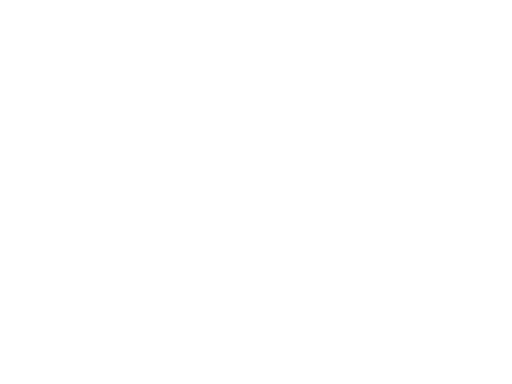

<IPython.core.display.Javascript object>


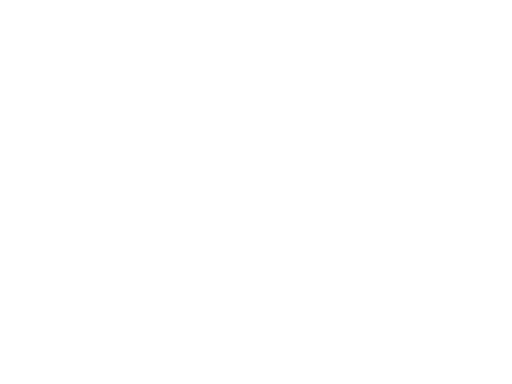

      fun: 71.89477661593911
 hess_inv: array([[3.0462268e-06]])
      jac: array([2.86102295e-06])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 8
     njev: 12
   status: 0
  success: True
        x: array([0.02908222])
[-0.04209813 -0.01310674  0.03885988 ...  0.01372518 -0.01652607
  0.0307018 ]
i:00 mean:-0.005263(0.000510) stdev:0.039408(0.000360) Nchanged:0 Nused:5980 Nskipped:0
i:01 mean:-0.002840(0.000267) stdev:0.020555(0.000189) Nchanged:59 Nused:5921 Nskipped:59
i:02 mean:-0.002285(0.000232) stdev:0.017697(0.000164) Nchanged:90 Nused:5831 Nskipped:149
i:03 mean:-0.002205(0.000227) stdev:0.017253(0.000160) Nchanged:32 Nused:5799 Nskipped:181
i:04 mean:-0.002169(0.000226) stdev:0.017179(0.000160) Nchanged:6 Nused:5793 Nskipped:187
i:05 mean:-0.002169(0.000226) stdev:0.017179(0.000160) Nchanged:0 Nused:5793 Nskipped:187
mean:-0.002169 (uncertainty:0.000226)


<IPython.core.display.Javascript object>


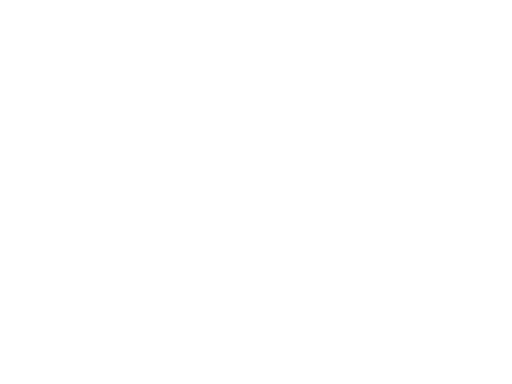

<IPython.core.display.Javascript object>


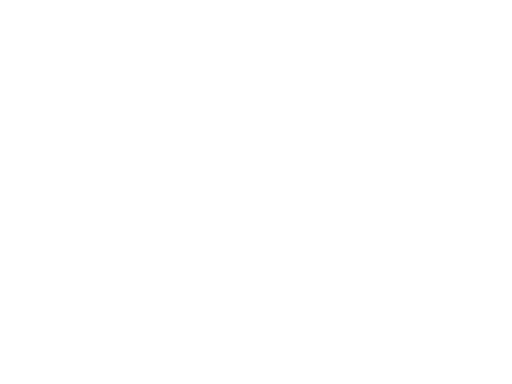

      fun: 121.81139523815182
 hess_inv: array([[4.7155755e-06]])
      jac: array([-2.86102295e-06])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 4
     njev: 7
   status: 0
  success: True
        x: array([0.02454511])
[-0.06275303 -0.01748345  0.06396372 ...  0.02380144 -0.02260407
  0.05228315]
i:00 mean:-0.002114(0.000782) stdev:0.060435(0.000553) Nchanged:0 Nused:5980 Nskipped:0
i:01 mean:-0.000663(0.000409) stdev:0.031466(0.000289) Nchanged:62 Nused:5918 Nskipped:62
i:02 mean:0.000318(0.000352) stdev:0.026900(0.000249) Nchanged:90 Nused:5828 Nskipped:152
i:03 mean:0.000482(0.000342) stdev:0.026041(0.000242) Nchanged:39 Nused:5789 Nskipped:191
i:04 mean:0.000496(0.000342) stdev:0.025984(0.000242) Nchanged:3 Nused:5786 Nskipped:194
i:05 mean:0.000510(0.000341) stdev:0.025966(0.000241) Nchanged:1 Nused:5785 Nskipped:195
i:06 mean:0.000510(0.000341) stdev:0.025966(0.000241) Nchanged:0 Nused:5785 Nskipped:195
mean:0.000510 (uncertainty:0.000341)


<IPython.core.display.Javascript object>


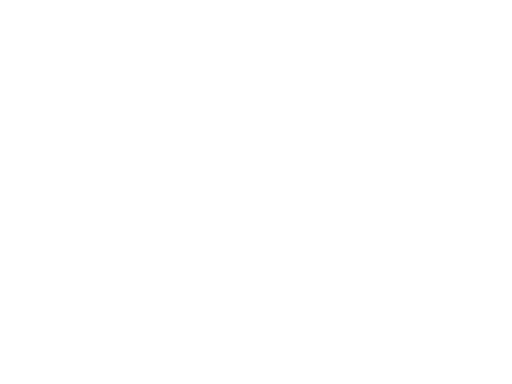

<IPython.core.display.Javascript object>


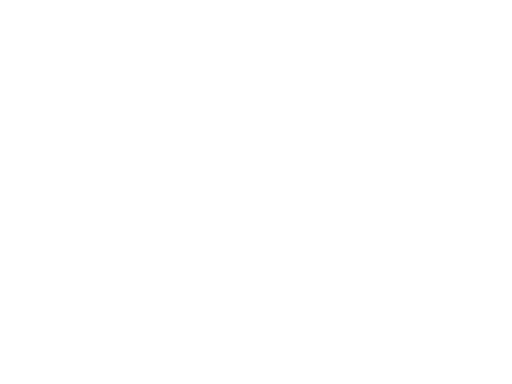

      fun: 105.44579052418243
 hess_inv: array([[4.03090353e-06]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([-0.01694958])
[ 0.06134447 -0.00917004  0.02101479 ...  0.00367289 -0.00519717
  0.02870435]
i:00 mean:0.002136(0.000872) stdev:0.067401(0.000616) Nchanged:0 Nused:5980 Nskipped:0
i:01 mean:0.002191(0.000355) stdev:0.027304(0.000251) Nchanged:60 Nused:5920 Nskipped:60
i:02 mean:0.001146(0.000284) stdev:0.021680(0.000201) Nchanged:104 Nused:5816 Nskipped:164
i:03 mean:0.000713(0.000269) stdev:0.020424(0.000190) Nchanged:64 Nused:5752 Nskipped:228
i:04 mean:0.000516(0.000265) stdev:0.020089(0.000188) Nchanged:22 Nused:5730 Nskipped:250
i:05 mean:0.000474(0.000265) stdev:0.020032(0.000187) Nchanged:4 Nused:5726 Nskipped:254
i:06 mean:0.000474(0.000265) stdev:0.020032(0.000187) Nchanged:0 Nused:5726 Nskipped:254
mean:0.000474 (uncertainty:0.000265)


<IPython.core.display.Javascript object>


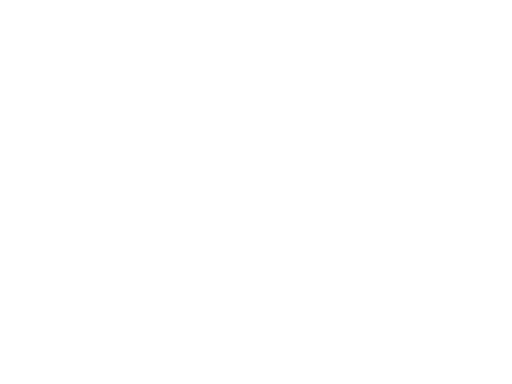

<IPython.core.display.Javascript object>


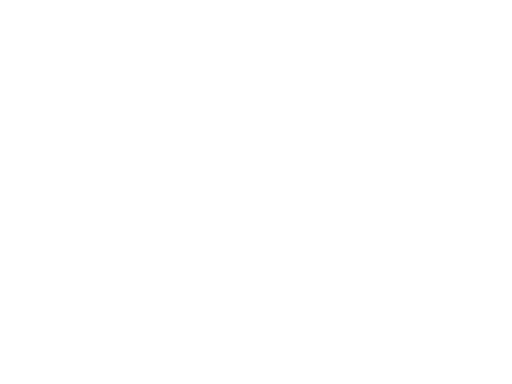

      fun: 84.07755754971615
 hess_inv: array([[2.69283945e-06]])
      jac: array([3.81469727e-06])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 6
     njev: 10
   status: 0
  success: True
        x: array([0.0256538])
[-4.49301881e-03  2.94337041e-02  3.25770916e-02  1.77721196e-02
  1.58460728e-02  3.27285057e-02  1.84792994e-02  1.42078062e-02
  1.27925119e-02 -1.08738976e-02 -8.89301731e-03 -9.47597796e-02
 -6.07930414e-03  2.34134792e-02  3.54217346e-02 -5.56440389e-03
  5.25636906e-03 -3.51197413e-02  2.76848773e-02  9.82052252e-03
  4.78771166e-03  2.05894618e-02  2.17605683e-02 -3.69524418e-02
 -1.24799235e-02  1.44007419e-02  8.80692473e-03  1.78132401e-02
  1.56601783e-02  9.63002987e-03  1.42433496e-03  1.98411639e-02
  3.53844690e-03 -2.31372546e-02  1.64532421e-02 -9.90265901e-03
  1.31553360e-02 -9.94200174e-03 -4.56428038e-02 -2.34915690e-02
  3.08843066e-02  2.21437907e-02  6.30536225e-03  3.17521511e-02
 -1.09054413e-02  1.94763940e-02 

<IPython.core.display.Javascript object>


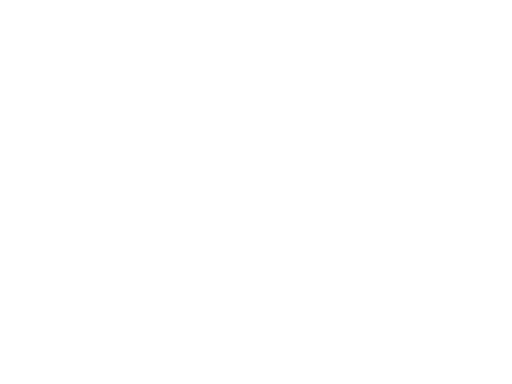

<IPython.core.display.Javascript object>


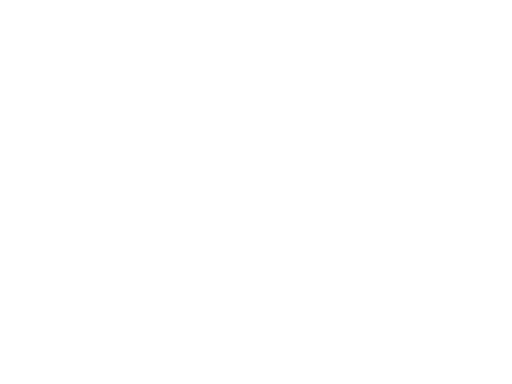

      fun: 16.941141043350186
 hess_inv: array([[4.78383736e-05]])
      jac: array([0.00014591])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 213
      nit: 7
     njev: 67
   status: 2
  success: False
        x: array([0.04245235])
[-1.04968149e-02  2.88432236e-02  3.41345955e-02  1.11531067e-02
  8.51617062e-03  3.54210285e-02  1.20050961e-02  6.34246981e-03
 -8.80720611e-03 -3.08944655e-02 -2.97120288e-02 -1.66977830e-01
 -9.26766623e-03  2.05097300e-02  3.95171894e-02 -2.02397372e-02
 -6.38544686e-03 -7.13236731e-02  2.74055687e-02 -1.28168859e-03
 -8.61607934e-03  1.45033617e-02  1.80470181e-02  4.18773261e-02
 -2.79412961e-03  6.65015426e-03 -2.85339606e-03  1.17146264e-02
  8.46778924e-03 -2.77120347e-02 -1.61937286e-02  1.47171458e-02
 -1.90740088e-02 -4.77854686e-02 -1.40322342e-02 -3.16002053e-02
  5.10600581e-03 -4.54594866e-03 -8.84762687e-02 -5.27467233e-02
  3.16132545e-02  1.86543438e-02 -1.11162316e-02  3.72013436e-02
 -2.43772

<IPython.core.display.Javascript object>


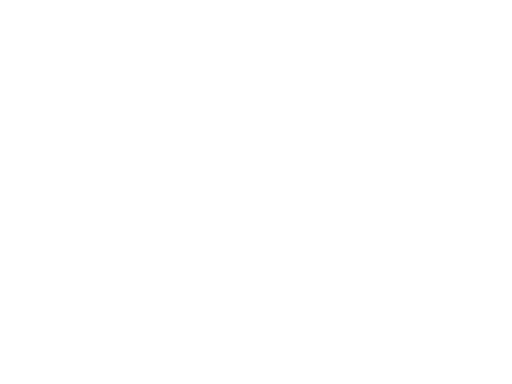

<IPython.core.display.Javascript object>


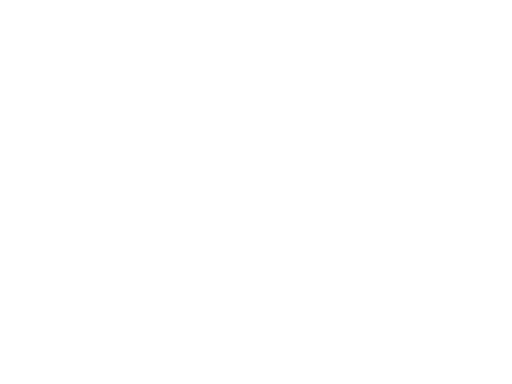

      fun: 18.39516105268369
 hess_inv: array([[4.67751975e-05]])
      jac: array([-2.86102295e-06])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 4
     njev: 7
   status: 0
  success: True
        x: array([-0.04040075])
[-2.38935718e-02 -8.93631377e-03 -6.47981019e-03 -1.02478891e-02
 -5.04024500e-03 -3.46134291e-03  2.25291722e-03  2.06679948e-03
 -4.35686088e-02 -1.31686077e-02 -1.18767831e-02  1.90347333e-01
  5.68485627e-03  2.12982656e-02 -3.13424890e-03 -4.46615122e-03
  2.11981347e-02 -3.87223892e-03  1.59599649e-02 -1.12082824e-02
 -1.54303020e-02  1.60058491e-02  7.35667101e-03 -7.95856676e-03
 -3.49970123e-02  2.68540634e-02 -4.51181400e-03  1.89406508e-02
  2.36027287e-02 -3.70602659e-02 -2.61854787e-02 -3.70140260e-02
  1.96937818e-02  2.66209073e-02 -8.48496946e-03  1.23055093e-02
  1.38297322e-02  7.84090434e-03  1.72483829e-02 -3.23607908e-02
  6.58793141e-03 -1.33656641e-02  3.05417156e-02 -1.46407128e-02
  7.73037433e-03 -1.45025016e-0

<IPython.core.display.Javascript object>


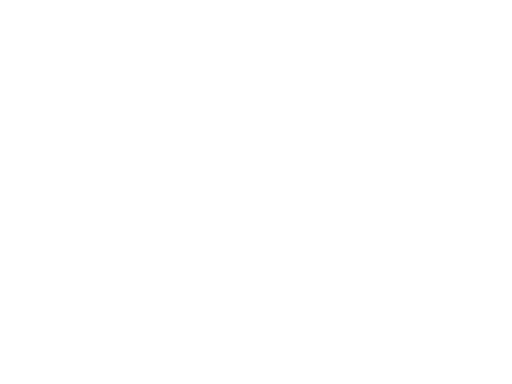

<IPython.core.display.Javascript object>


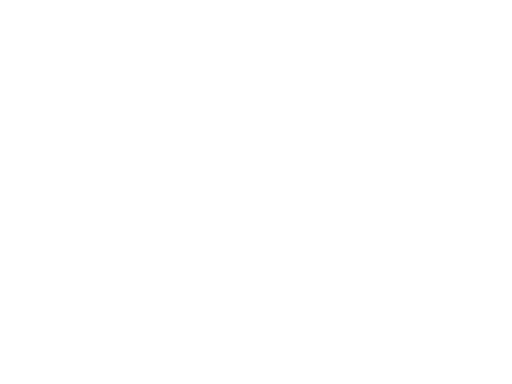

      fun: 12.3305382406956
 hess_inv: array([[2.64759806e-05]])
      jac: array([7.31945038e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 215
      nit: 4
     njev: 68
   status: 2
  success: False
        x: array([0.04484732])
[-0.01368993 -0.00286782  0.00232637 ... -0.01646677 -0.00924442
 -0.01478415]
i:00 mean:-0.009911(0.000681) stdev:0.046608(0.000482) Nchanged:0 Nused:4679 Nskipped:0
i:01 mean:-0.008659(0.000315) stdev:0.021473(0.000223) Nchanged:43 Nused:4636 Nskipped:43
i:02 mean:-0.008215(0.000257) stdev:0.017370(0.000182) Nchanged:80 Nused:4556 Nskipped:123
i:03 mean:-0.008282(0.000245) stdev:0.016443(0.000173) Nchanged:46 Nused:4510 Nskipped:169
i:04 mean:-0.008373(0.000242) stdev:0.016219(0.000171) Nchanged:14 Nused:4496 Nskipped:183
i:05 mean:-0.008395(0.000241) stdev:0.016160(0.000170) Nchanged:4 Nused:4492 Nskipped:187
i:06 mean:-0.008406(0.000241) stdev:0.016146(0.000170) Nchanged:1 Nused:4491 Nskipped:188
i:07 mean:-0

<IPython.core.display.Javascript object>


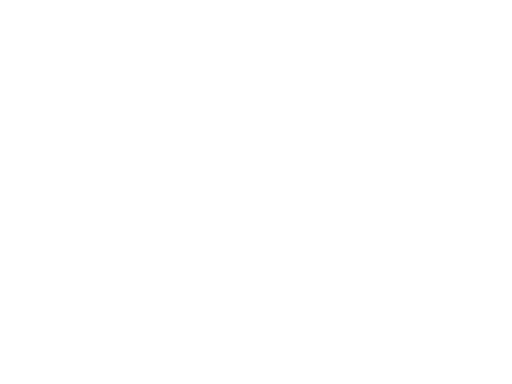

<IPython.core.display.Javascript object>


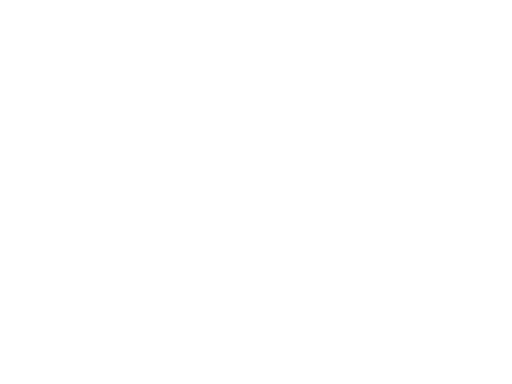

      fun: 87.78273867523409
 hess_inv: array([[5.67810269e-06]])
      jac: array([-9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 33
      nit: 7
     njev: 11
   status: 0
  success: True
        x: array([0.02983765])
[-0.00527473  0.01510791  0.01628354 ... -0.01005229 -0.0042101
 -0.0061773 ]
i:00 mean:-0.000899(0.001078) stdev:0.073744(0.000762) Nchanged:0 Nused:4679 Nskipped:0
i:01 mean:-0.000126(0.000481) stdev:0.032716(0.000340) Nchanged:46 Nused:4633 Nskipped:46
i:02 mean:0.000503(0.000388) stdev:0.026188(0.000275) Nchanged:83 Nused:4550 Nskipped:129
i:03 mean:0.000317(0.000367) stdev:0.024607(0.000259) Nchanged:50 Nused:4500 Nskipped:179
i:04 mean:0.000282(0.000363) stdev:0.024319(0.000257) Nchanged:12 Nused:4488 Nskipped:191
i:05 mean:0.000233(0.000362) stdev:0.024253(0.000256) Nchanged:3 Nused:4485 Nskipped:194
i:06 mean:0.000233(0.000362) stdev:0.024253(0.000256) Nchanged:0 Nused:4485 Nskipped:194
mean:0.000233 (uncertainty:0.000362)


<IPython.core.display.Javascript object>


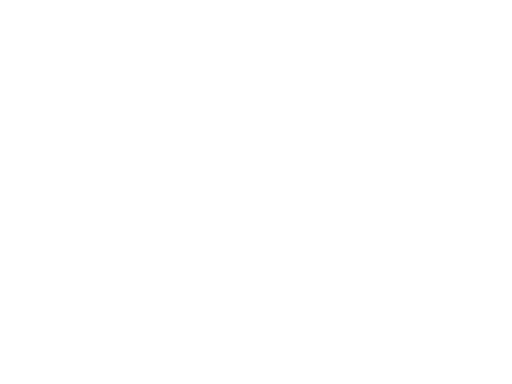

<IPython.core.display.Javascript object>


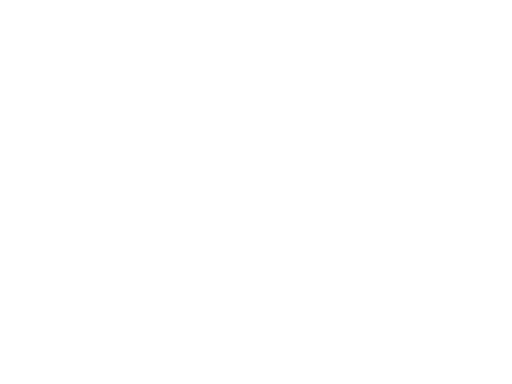

      fun: 65.97644828178478
 hess_inv: array([[4.78628017e-06]])
      jac: array([9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 27
      nit: 6
     njev: 9
   status: 0
  success: True
        x: array([-0.01848478])
[ 0.00536567 -0.00201141  0.03122066 ... -0.00426317 -0.01556257
  0.0051399 ]
i:00 mean:0.002098(0.001079) stdev:0.073778(0.000763) Nchanged:0 Nused:4679 Nskipped:0
i:01 mean:0.001907(0.000349) stdev:0.023735(0.000247) Nchanged:53 Nused:4626 Nskipped:53
i:02 mean:0.000661(0.000270) stdev:0.018265(0.000191) Nchanged:62 Nused:4564 Nskipped:115
i:03 mean:0.000331(0.000262) stdev:0.017617(0.000185) Nchanged:30 Nused:4534 Nskipped:145
i:04 mean:0.000284(0.000260) stdev:0.017487(0.000184) Nchanged:8 Nused:4526 Nskipped:153
i:05 mean:0.000272(0.000260) stdev:0.017472(0.000184) Nchanged:1 Nused:4525 Nskipped:154
i:06 mean:0.000272(0.000260) stdev:0.017472(0.000184) Nchanged:0 Nused:4525 Nskipped:154
mean:0.000272 (uncertainty:0.000260)


<IPython.core.display.Javascript object>


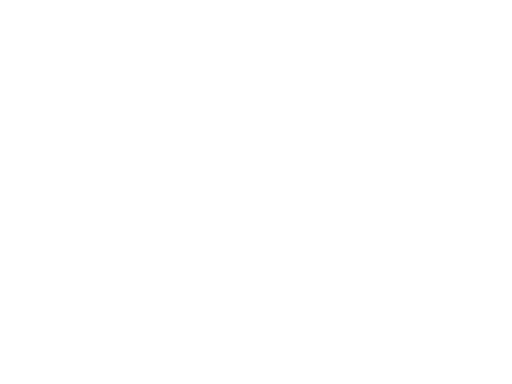

<IPython.core.display.Javascript object>


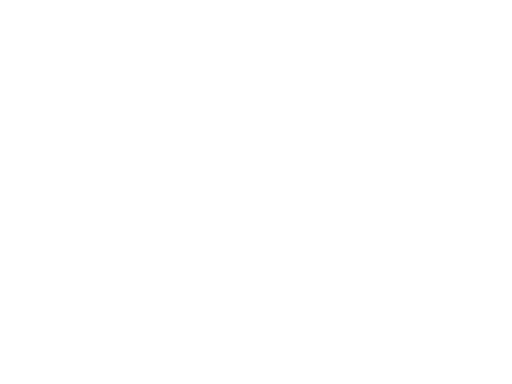

      fun: 64.88088371609301
 hess_inv: array([[3.4069543e-06]])
      jac: array([0.00203609])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 140
      nit: 7
     njev: 43
   status: 2
  success: False
        x: array([0.03035231])


<IPython.core.display.Javascript object>


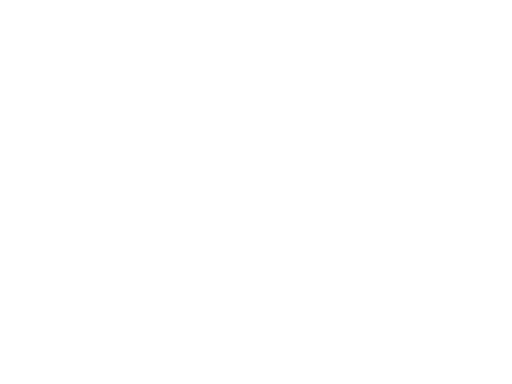

<IPython.core.display.Javascript object>


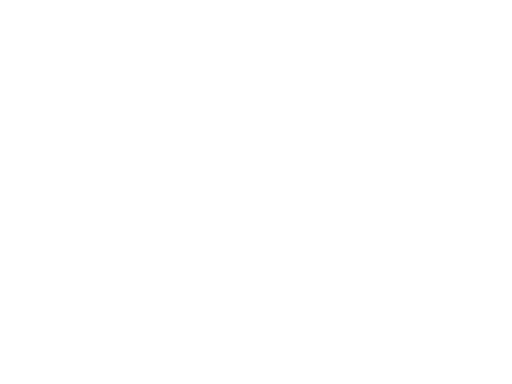

      fun: inf
 hess_inv: array([[1]])
      jac: array([nan])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.])


<IPython.core.display.Javascript object>


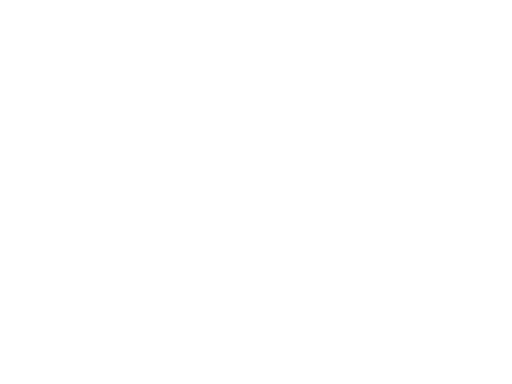

<IPython.core.display.Javascript object>


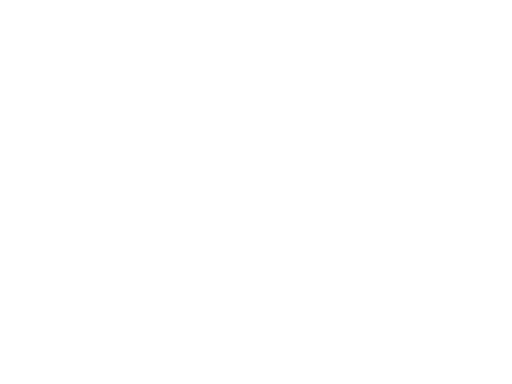

      fun: inf
 hess_inv: array([[1]])
      jac: array([nan])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.])


<IPython.core.display.Javascript object>


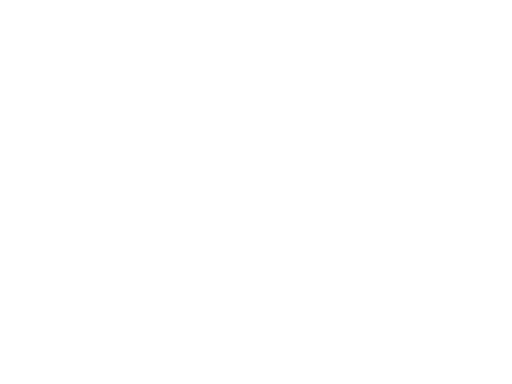

<IPython.core.display.Javascript object>


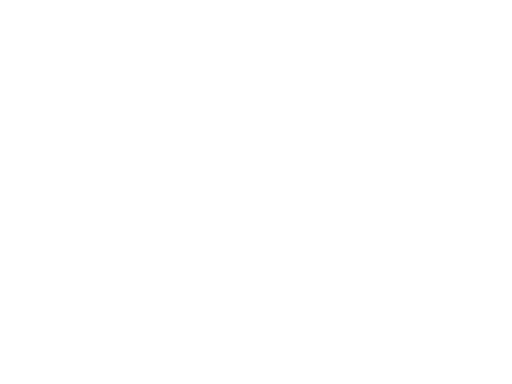

      fun: inf
 hess_inv: array([[1]])
      jac: array([nan])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.])


<IPython.core.display.Javascript object>


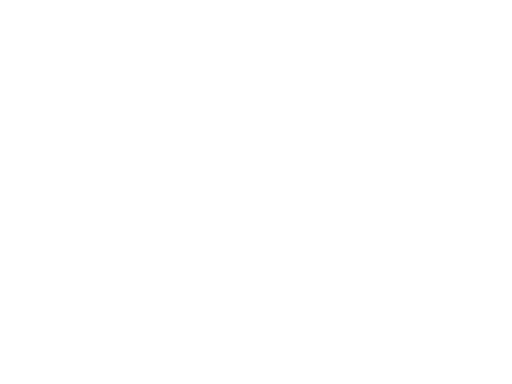

<IPython.core.display.Javascript object>


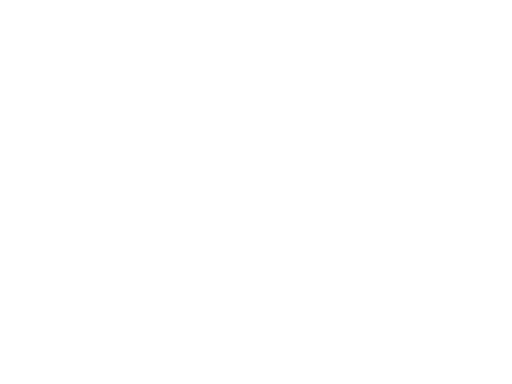

      fun: inf
 hess_inv: array([[1]])
      jac: array([nan])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.])


<IPython.core.display.Javascript object>


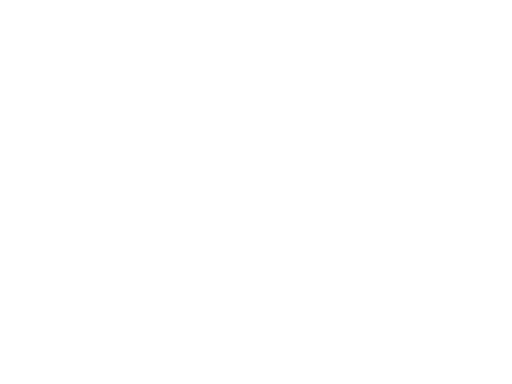

<IPython.core.display.Javascript object>


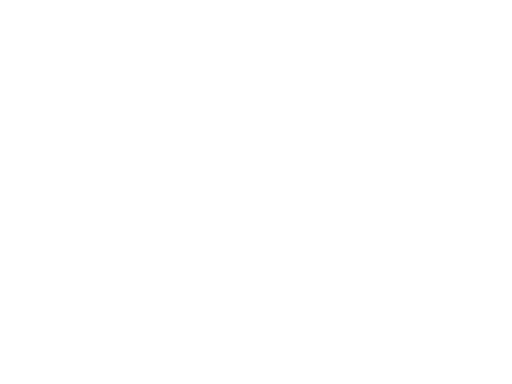

      fun: inf
 hess_inv: array([[1]])
      jac: array([nan])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.])


<IPython.core.display.Javascript object>


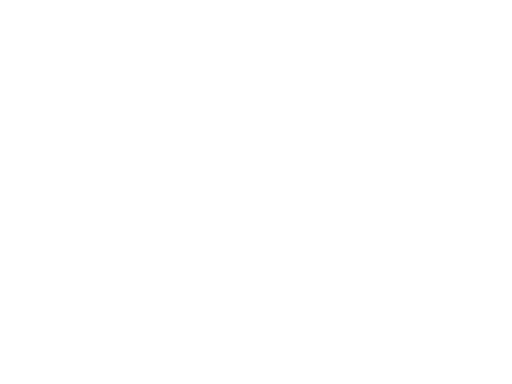

<IPython.core.display.Javascript object>


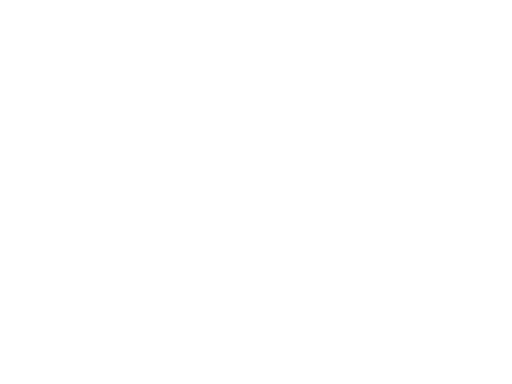

      fun: inf
 hess_inv: array([[1]])
      jac: array([nan])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.])
[ 0.0566941   0.19230227 -0.01657444  0.62366279  0.03546805  0.02112149
  0.04565643  0.15544858 -0.05516069  0.04311024  0.05287494  0.0620995
  0.06648624 -0.77310212  0.06641261  0.07012043  0.03521534  0.08377985
  0.02968426  0.03005591  0.05251416 -0.01469415  0.01187968  0.02480988
 -0.40435709  0.02369365 -0.0066053   0.03606842 -0.05499742  0.05353948
  1.0615669   0.00617787  0.04342398  0.1002103   0.03105841  0.10114331
  0.03999815  0.02699328  0.06712952 -0.00966028  0.16852026 -0.01278733
 -0.01333112  0.04154476  0.00199767  0.02531882 -0.02809873  0.01363158
 -0.00650454  0.02808244  0.0079903   0.00913068  0.02239409  0.02917685
  0.02292916 -0.04042491  0.05996489  0.04558122 -0.0044986   0.02709849
  0.01573076  0.23930441  0.0694536   0.07138315  0.09877785  0.07

<IPython.core.display.Javascript object>


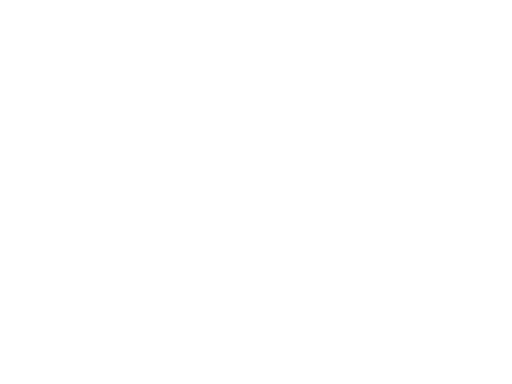

<IPython.core.display.Javascript object>


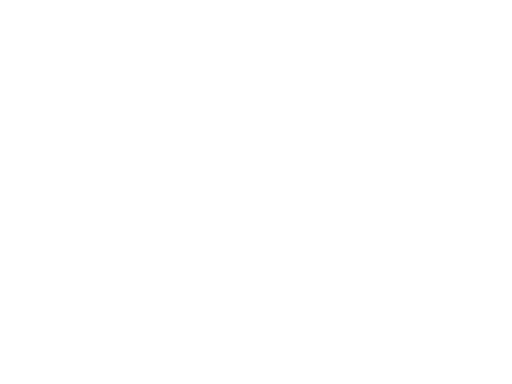

      fun: 16.121951897991522
 hess_inv: array([[7.95526152e-05]])
      jac: array([8.77380371e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 219
      nit: 7
     njev: 69
   status: 2
  success: False
        x: array([0.04342353])
[ 4.76768228e-02  2.57684465e-01 -6.61188111e-02  6.26929564e-01
  1.17140886e-02 -1.02090471e-02  3.60815645e-02  1.12802819e-01
 -1.27289898e-01  2.64501125e-02  4.14779560e-02  5.57391692e-02
  6.66405746e-02 -1.28450987e+00  6.74065895e-02  7.77695012e-02
  2.44685168e-02  6.06924347e-02  8.65608034e-03  7.78341132e-03
  4.79103786e-02 -6.30900218e-02 -2.08320188e-02 -3.05257198e-03
 -6.89943802e-01 -6.91380044e-03 -4.36103195e-02  1.42409986e-02
 -1.27578036e-01  4.50735128e-02  1.02919256e+00 -4.08743248e-02
  2.14170829e-02  1.20220640e-01  6.36818698e-03  8.05917398e-02
  2.02419905e-02 -4.32961771e-03  6.66593317e-02 -4.50417779e-02
  2.29976362e-01 -6.22151702e-02 -5.92883096e-02  2.22630373e-02
 -4.0

<IPython.core.display.Javascript object>


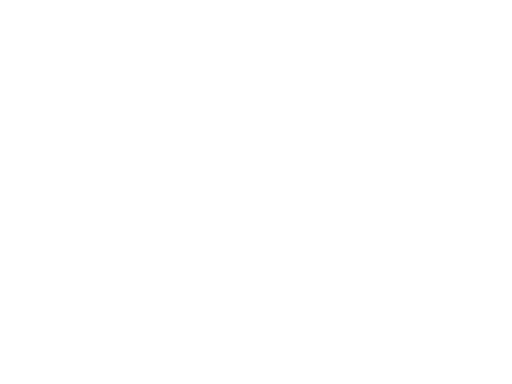

<IPython.core.display.Javascript object>


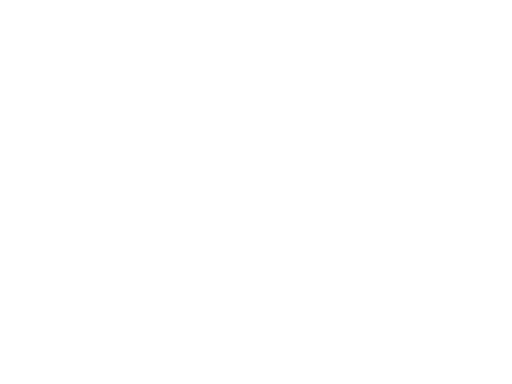

      fun: 17.685501141562042
 hess_inv: array([[0.00010563]])
      jac: array([4.76837158e-06])
  message: 'Optimization terminated successfully.'
     nfev: 33
      nit: 8
     njev: 11
   status: 0
  success: True
        x: array([-0.05257146])
[ 3.94033601e-02 -2.66778051e-02  1.02811250e-01 -5.69332766e-01
  1.56450885e-01 -4.74761399e-02  1.10706725e-01  6.36913214e-02
  9.84555888e-02  3.06621352e-01  1.22951045e-02  1.19547694e-01
 -1.90361054e-02  1.21926136e+00 -1.30759619e-01  7.31813246e-02
  6.24908843e-03  5.13065418e-02 -1.09737505e-02 -2.36120506e-02
  1.38477775e-01 -4.41457611e-02 -1.94763095e-02  5.33125222e-02
  7.64041957e-01  5.04893838e-02  1.42743577e-02  2.27173340e-02
  1.35520202e-01  9.38356298e-02  6.72204122e-01 -2.98063672e-02
 -1.08397516e-01  4.14261118e-02  9.74462644e-02  6.25194010e-02
  3.18181643e-02  1.82000894e-02  1.45468781e-01  9.06968216e-02
  1.18987862e-01  3.62220515e-02 -5.96374736e-02  9.31846239e-02
  6.05265804e-02  5.69276616e-02 -

<IPython.core.display.Javascript object>


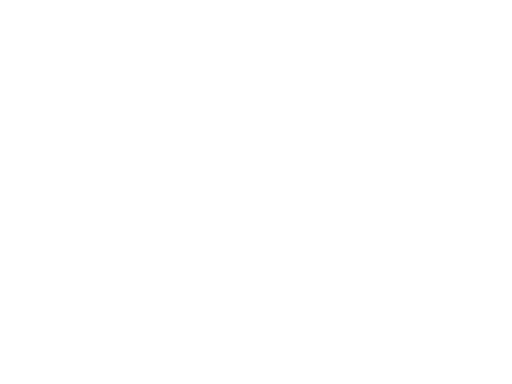

<IPython.core.display.Javascript object>


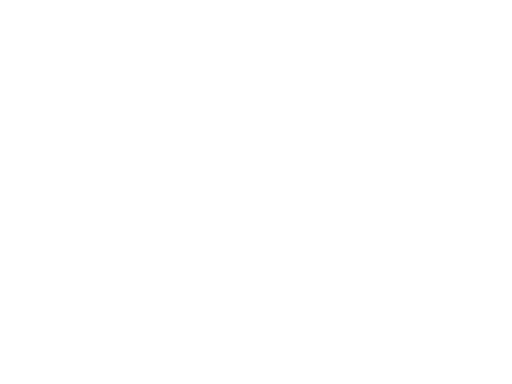

      fun: 17.327435626605116
 hess_inv: array([[4.92680221e-05]])
      jac: array([0.00014424])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 204
      nit: 3
     njev: 64
   status: 2
  success: False
        x: array([0.04814124])
[-0.00654258 -0.01084945  0.0067058  ... -0.00431888  0.04281834
  0.010405  ]
i:00 mean:-0.013419(0.000381) stdev:0.038126(0.000269) Nchanged:0 Nused:10008 Nskipped:0
i:01 mean:-0.011933(0.000191) stdev:0.019000(0.000135) Nchanged:107 Nused:9901 Nskipped:107
i:02 mean:-0.011506(0.000170) stdev:0.016826(0.000120) Nchanged:135 Nused:9766 Nskipped:242
i:03 mean:-0.011452(0.000166) stdev:0.016345(0.000117) Nchanged:59 Nused:9707 Nskipped:301
i:04 mean:-0.011472(0.000165) stdev:0.016247(0.000117) Nchanged:14 Nused:9693 Nskipped:315
i:05 mean:-0.011457(0.000165) stdev:0.016227(0.000117) Nchanged:3 Nused:9690 Nskipped:318
i:06 mean:-0.011457(0.000165) stdev:0.016227(0.000117) Nchanged:0 Nused:9690 Nskipped:318
mean:-0.01

<IPython.core.display.Javascript object>


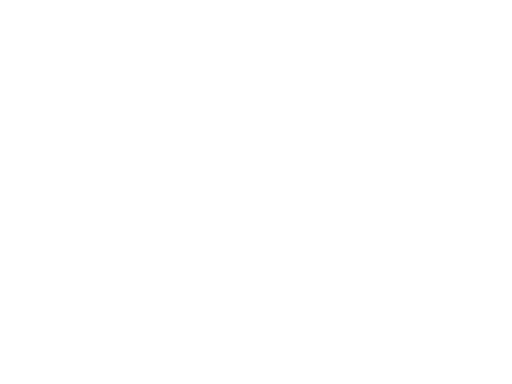

<IPython.core.display.Javascript object>


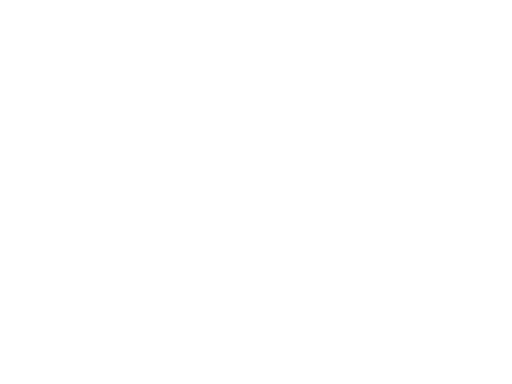

      fun: 187.6249261920455
 hess_inv: array([[2.54030567e-06]])
      jac: array([0.00272751])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 176
      nit: 6
     njev: 55
   status: 2
  success: False
        x: array([0.02697008])
[0.01596891 0.00546346 0.0198227  ... 0.01425864 0.08043211 0.03535938]
i:00 mean:-0.001939(0.000592) stdev:0.059209(0.000419) Nchanged:0 Nused:10008 Nskipped:0
i:01 mean:-0.000165(0.000288) stdev:0.028644(0.000204) Nchanged:110 Nused:9898 Nskipped:110
i:02 mean:0.000638(0.000252) stdev:0.024890(0.000178) Nchanged:152 Nused:9746 Nskipped:262
i:03 mean:0.000745(0.000245) stdev:0.024142(0.000173) Nchanged:61 Nused:9685 Nskipped:323
i:04 mean:0.000738(0.000244) stdev:0.023946(0.000172) Nchanged:19 Nused:9666 Nskipped:342
i:05 mean:0.000715(0.000243) stdev:0.023875(0.000172) Nchanged:7 Nused:9659 Nskipped:349
i:06 mean:0.000715(0.000243) stdev:0.023875(0.000172) Nchanged:0 Nused:9659 Nskipped:349
mean:0.000715 (uncertai

<IPython.core.display.Javascript object>


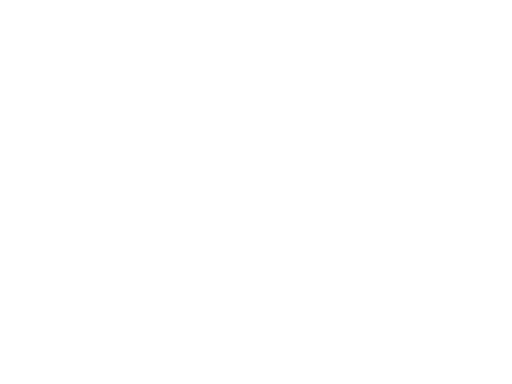

<IPython.core.display.Javascript object>


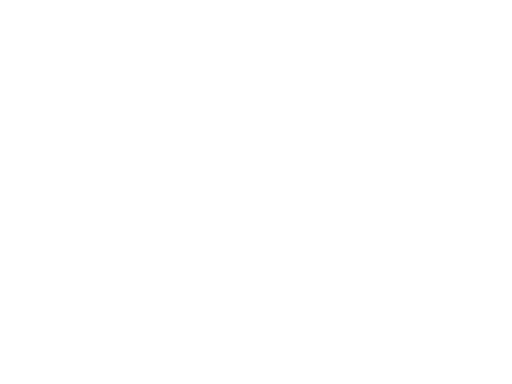

      fun: 159.75995373960325
 hess_inv: array([[2.42194148e-06]])
      jac: array([7.62939453e-06])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 4
     njev: 7
   status: 0
  success: True
        x: array([-0.01436522])
[ 0.00292522 -0.02590586 -0.02003353 ... -0.00654101  0.039052
  0.02064528]
i:00 mean:0.002181(0.000591) stdev:0.059105(0.000418) Nchanged:0 Nused:10008 Nskipped:0
i:01 mean:0.001992(0.000247) stdev:0.024608(0.000175) Nchanged:107 Nused:9901 Nskipped:107
i:02 mean:0.000731(0.000205) stdev:0.020292(0.000145) Nchanged:145 Nused:9756 Nskipped:252
i:03 mean:0.000503(0.000198) stdev:0.019526(0.000140) Nchanged:73 Nused:9683 Nskipped:325
i:04 mean:0.000423(0.000196) stdev:0.019297(0.000139) Nchanged:27 Nused:9656 Nskipped:352
i:05 mean:0.000405(0.000196) stdev:0.019240(0.000138) Nchanged:7 Nused:9649 Nskipped:359
i:06 mean:0.000405(0.000196) stdev:0.019240(0.000138) Nchanged:0 Nused:9649 Nskipped:359
mean:0.000405 (uncertainty:0.000196)


<IPython.core.display.Javascript object>


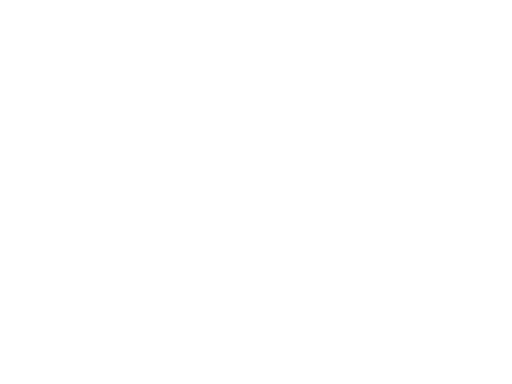

<IPython.core.display.Javascript object>


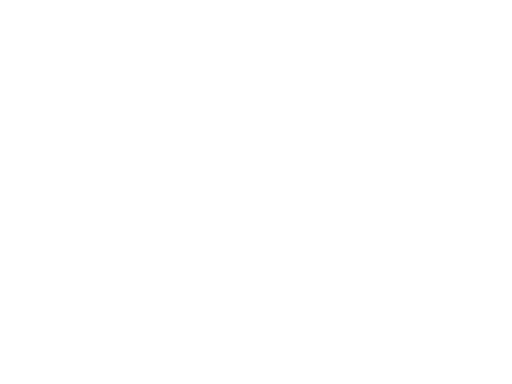

      fun: 134.60205582207618
 hess_inv: array([[1.55001655e-06]])
      jac: array([0.00466347])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 146
      nit: 6
     njev: 45
   status: 2
  success: False
        x: array([0.02747331])
[ 0.02902513 -0.01307147 -0.01006822 ... -0.0135736   0.01159535
  0.02577082]
i:00 mean:-0.005800(0.002048) stdev:0.185412(0.001448) Nchanged:0 Nused:8194 Nskipped:0
i:01 mean:0.001794(0.000723) stdev:0.064513(0.000511) Nchanged:225 Nused:7969 Nskipped:225
i:02 mean:-0.003262(0.000263) stdev:0.023207(0.000186) Nchanged:191 Nused:7778 Nskipped:416
i:03 mean:-0.003154(0.000192) stdev:0.016775(0.000136) Nchanged:140 Nused:7638 Nskipped:556
i:04 mean:-0.003212(0.000182) stdev:0.015812(0.000129) Nchanged:76 Nused:7562 Nskipped:632
i:05 mean:-0.003161(0.000180) stdev:0.015598(0.000127) Nchanged:24 Nused:7538 Nskipped:656
i:06 mean:-0.003173(0.000179) stdev:0.015530(0.000127) Nchanged:8 Nused:7530 Nskipped:664
i:07 mean:

<IPython.core.display.Javascript object>


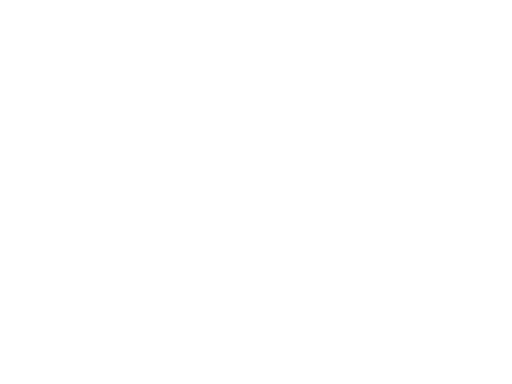

<IPython.core.display.Javascript object>


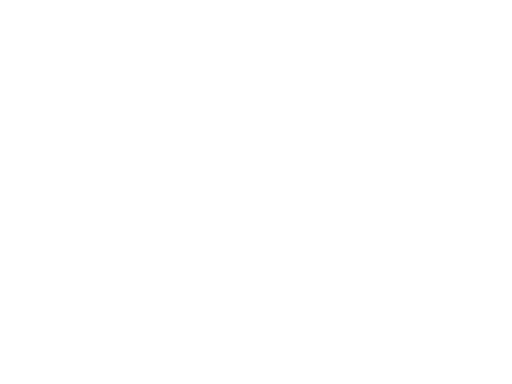

      fun: 139.42433312060325
 hess_inv: array([[2.95263762e-06]])
      jac: array([-3.81469727e-06])
  message: 'Optimization terminated successfully.'
     nfev: 27
      nit: 6
     njev: 9
   status: 0
  success: True
        x: array([0.01981221])
[ 0.05303076 -0.01324931 -0.00752703 ... -0.01031003  0.02558651
  0.04840425]
i:00 mean:0.002518(0.002490) stdev:0.225433(0.001761) Nchanged:0 Nused:8194 Nskipped:0
i:01 mean:0.008452(0.000937) stdev:0.083624(0.000663) Nchanged:233 Nused:7961 Nskipped:233
i:02 mean:0.001701(0.000377) stdev:0.033213(0.000267) Nchanged:199 Nused:7762 Nskipped:432
i:03 mean:0.001518(0.000286) stdev:0.024982(0.000202) Nchanged:137 Nused:7625 Nskipped:569
i:04 mean:0.001529(0.000271) stdev:0.023557(0.000192) Nchanged:77 Nused:7548 Nskipped:646
i:05 mean:0.001529(0.000266) stdev:0.023099(0.000188) Nchanged:34 Nused:7514 Nskipped:680
i:06 mean:0.001520(0.000264) stdev:0.022884(0.000187) Nchanged:17 Nused:7497 Nskipped:697
i:07 mean:0.001529(0.000264) stdev:0.

<IPython.core.display.Javascript object>


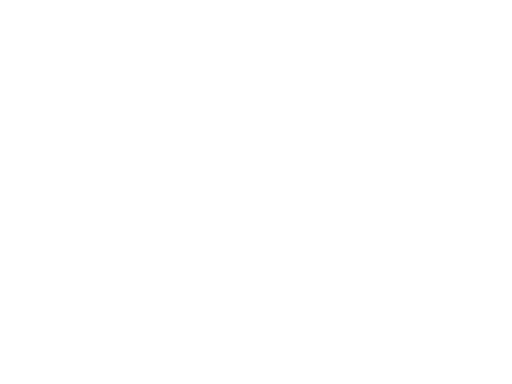

<IPython.core.display.Javascript object>


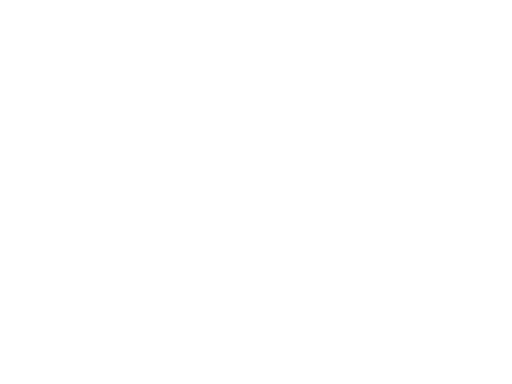

      fun: 127.11070145117945
 hess_inv: array([[2.63536997e-06]])
      jac: array([-9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 27
      nit: 6
     njev: 9
   status: 0
  success: True
        x: array([-0.01785589])
[-0.04460379  0.0037959  -0.02842947 ... -0.01005912  0.02006018
  0.00130925]
i:00 mean:0.003223(0.002080) stdev:0.188269(0.001471) Nchanged:0 Nused:8194 Nskipped:0
i:01 mean:0.014499(0.000766) stdev:0.069032(0.000541) Nchanged:65 Nused:8129 Nskipped:65
i:02 mean:0.003783(0.000358) stdev:0.031686(0.000253) Nchanged:276 Nused:7853 Nskipped:341
i:03 mean:0.001224(0.000251) stdev:0.021995(0.000178) Nchanged:177 Nused:7676 Nskipped:518
i:04 mean:0.000729(0.000230) stdev:0.020026(0.000163) Nchanged:109 Nused:7567 Nskipped:627
i:05 mean:0.000705(0.000224) stdev:0.019447(0.000159) Nchanged:49 Nused:7518 Nskipped:676
i:06 mean:0.000697(0.000222) stdev:0.019200(0.000157) Nchanged:23 Nused:7495 Nskipped:699
i:07 mean:0.000697(0.000221) stdev:0.

<IPython.core.display.Javascript object>


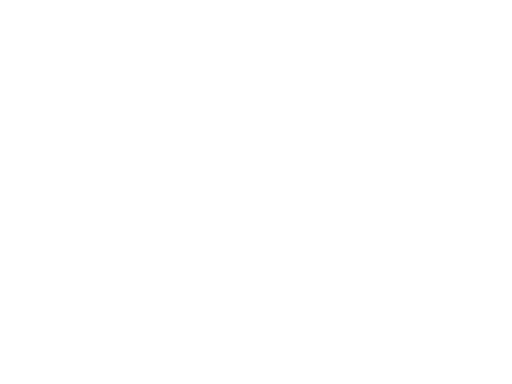

<IPython.core.display.Javascript object>


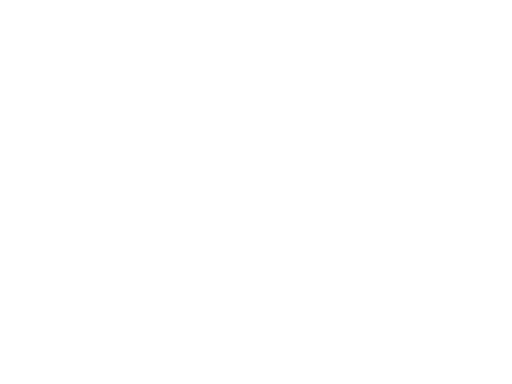

      fun: 104.60560315811324
 hess_inv: array([[1.93675291e-06]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 45
      nit: 6
     njev: 15
   status: 0
  success: True
        x: array([0.02123243])
[-0.01410438  0.03606254 -0.0106371  ...  0.00941802  0.01285555
  0.02623907]
i:00 mean:0.007720(0.001437) stdev:0.082896(0.001016) Nchanged:0 Nused:3326 Nskipped:0
i:01 mean:0.005616(0.000476) stdev:0.027373(0.000337) Nchanged:23 Nused:3303 Nskipped:23
i:02 mean:0.005976(0.000338) stdev:0.019214(0.000239) Nchanged:72 Nused:3231 Nskipped:95
i:03 mean:0.006250(0.000310) stdev:0.017470(0.000219) Nchanged:48 Nused:3183 Nskipped:143
i:04 mean:0.006268(0.000305) stdev:0.017195(0.000216) Nchanged:11 Nused:3172 Nskipped:154
i:05 mean:0.006284(0.000305) stdev:0.017173(0.000216) Nchanged:1 Nused:3171 Nskipped:155
i:06 mean:0.006284(0.000305) stdev:0.017173(0.000216) Nchanged:0 Nused:3171 Nskipped:155
mean:0.006284 (uncertainty:0.000305)


<IPython.core.display.Javascript object>


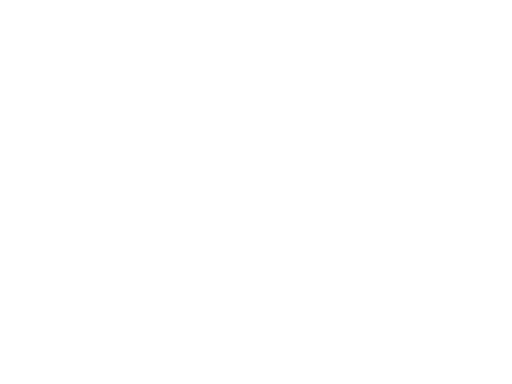

<IPython.core.display.Javascript object>


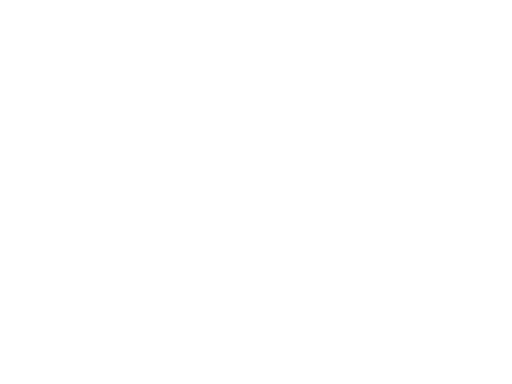

      fun: 66.08639006937443
 hess_inv: array([[8.95423538e-06]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 27
      nit: 6
     njev: 9
   status: 0
  success: True
        x: array([0.0311593])
[-0.03174932  0.04835739 -0.02605028 ...  0.00522607  0.00904754
  0.0308572 ]
i:00 mean:0.000123(0.001718) stdev:0.099105(0.001215) Nchanged:0 Nused:3326 Nskipped:0
i:01 mean:-0.000608(0.000684) stdev:0.039254(0.000484) Nchanged:31 Nused:3295 Nskipped:31
i:02 mean:0.000334(0.000501) stdev:0.028438(0.000354) Nchanged:71 Nused:3224 Nskipped:102
i:03 mean:0.000889(0.000463) stdev:0.026090(0.000327) Nchanged:42 Nused:3182 Nskipped:144
i:04 mean:0.000915(0.000455) stdev:0.025605(0.000322) Nchanged:13 Nused:3169 Nskipped:157
i:05 mean:0.000963(0.000454) stdev:0.025540(0.000321) Nchanged:2 Nused:3167 Nskipped:159
i:06 mean:0.000963(0.000454) stdev:0.025540(0.000321) Nchanged:0 Nused:3167 Nskipped:159
mean:0.000963 (uncertainty:0.000454)


<IPython.core.display.Javascript object>


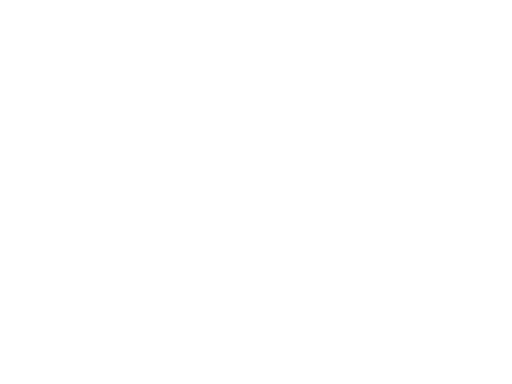

<IPython.core.display.Javascript object>


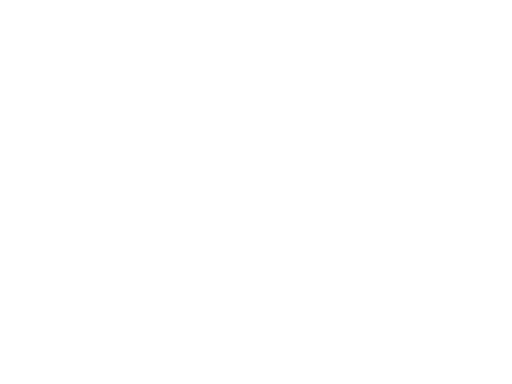

      fun: 61.10702568364006
 hess_inv: array([[8.14416314e-06]])
      jac: array([4.76837158e-07])
  message: 'Optimization terminated successfully.'
     nfev: 27
      nit: 6
     njev: 9
   status: 0
  success: True
        x: array([-0.01832334])
[-0.03965879 -0.01430967 -0.00426157 ...  0.006316    0.00903358
  0.00579204]
i:00 mean:0.000924(0.001130) stdev:0.065196(0.000799) Nchanged:0 Nused:3326 Nskipped:0
i:01 mean:0.000019(0.000520) stdev:0.029765(0.000368) Nchanged:54 Nused:3272 Nskipped:54
i:02 mean:-0.000431(0.000406) stdev:0.022947(0.000287) Nchanged:71 Nused:3201 Nskipped:125
i:03 mean:-0.000362(0.000388) stdev:0.021862(0.000274) Nchanged:27 Nused:3174 Nskipped:152
i:04 mean:-0.000341(0.000385) stdev:0.021658(0.000272) Nchanged:7 Nused:3167 Nskipped:159
i:05 mean:-0.000320(0.000384) stdev:0.021630(0.000272) Nchanged:1 Nused:3166 Nskipped:160
i:06 mean:-0.000320(0.000384) stdev:0.021630(0.000272) Nchanged:0 Nused:3166 Nskipped:160
mean:-0.000320 (uncertainty:0.000384)


<IPython.core.display.Javascript object>


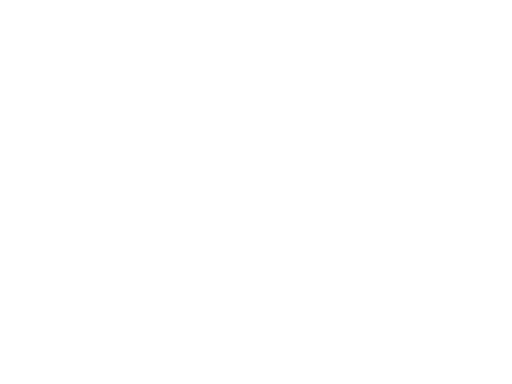

<IPython.core.display.Javascript object>


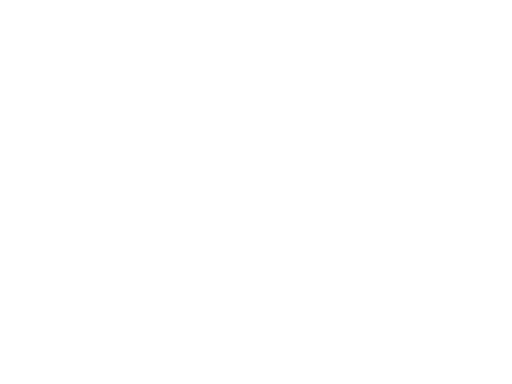

      fun: 48.39138531229242
 hess_inv: array([[5.11326945e-06]])
      jac: array([1.43051147e-06])
  message: 'Optimization terminated successfully.'
     nfev: 39
      nit: 7
     njev: 13
   status: 0
  success: True
        x: array([0.03105188])
[ 0.00807258  0.01580182  0.00968823 ... -0.02932096 -0.16797351
 -0.02468197]
i:00 mean:-0.006916(0.000908) stdev:0.054174(0.000642) Nchanged:0 Nused:3562 Nskipped:0
i:01 mean:-0.006609(0.000397) stdev:0.023542(0.000281) Nchanged:44 Nused:3518 Nskipped:44
i:02 mean:-0.005033(0.000313) stdev:0.018418(0.000222) Nchanged:65 Nused:3453 Nskipped:109
i:03 mean:-0.004847(0.000300) stdev:0.017569(0.000212) Nchanged:28 Nused:3425 Nskipped:137
i:04 mean:-0.004846(0.000295) stdev:0.017212(0.000208) Nchanged:16 Nused:3409 Nskipped:153
i:05 mean:-0.004800(0.000293) stdev:0.017107(0.000207) Nchanged:5 Nused:3404 Nskipped:158
i:06 mean:-0.004785(0.000293) stdev:0.017087(0.000207) Nchanged:1 Nused:3403 Nskipped:159
i:07 mean:-0.004785(0.000293) stdev:0

<IPython.core.display.Javascript object>


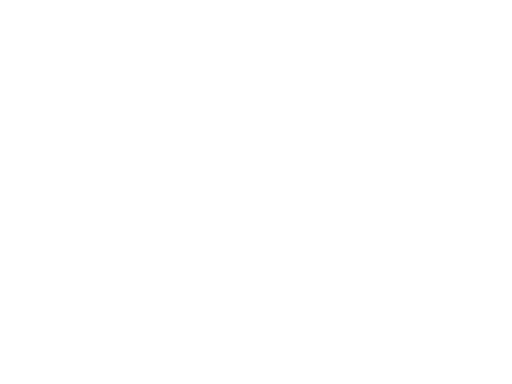

<IPython.core.display.Javascript object>


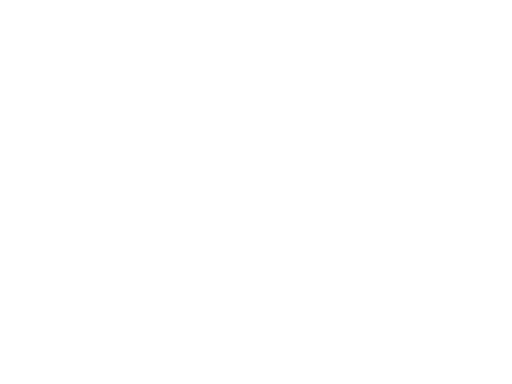

      fun: 71.43064153637084
 hess_inv: array([[8.39744831e-06]])
      jac: array([2.86102295e-06])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([0.02415143])
[-0.00548149  0.03137614 -0.0023306  ... -0.03985214 -0.26384333
 -0.03258686]
i:00 mean:-0.002205(0.001305) stdev:0.077883(0.000923) Nchanged:0 Nused:3562 Nskipped:0
i:01 mean:-0.003825(0.000584) stdev:0.034610(0.000413) Nchanged:51 Nused:3511 Nskipped:51
i:02 mean:-0.001584(0.000470) stdev:0.027619(0.000333) Nchanged:62 Nused:3449 Nskipped:113
i:03 mean:-0.001127(0.000449) stdev:0.026227(0.000317) Nchanged:33 Nused:3416 Nskipped:146
i:04 mean:-0.001148(0.000443) stdev:0.025863(0.000313) Nchanged:11 Nused:3405 Nskipped:157
i:05 mean:-0.001171(0.000442) stdev:0.025771(0.000312) Nchanged:3 Nused:3402 Nskipped:160
i:06 mean:-0.001171(0.000442) stdev:0.025771(0.000312) Nchanged:0 Nused:3402 Nskipped:160
mean:-0.001171 (uncertainty:0.000442)


<IPython.core.display.Javascript object>


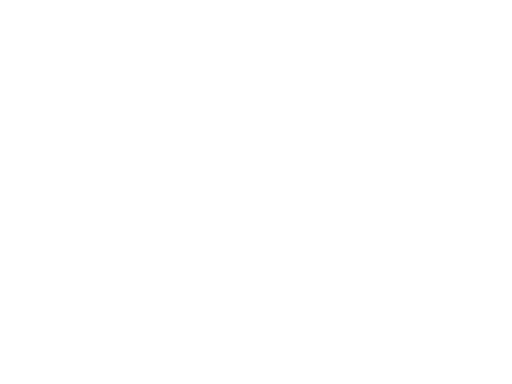

<IPython.core.display.Javascript object>


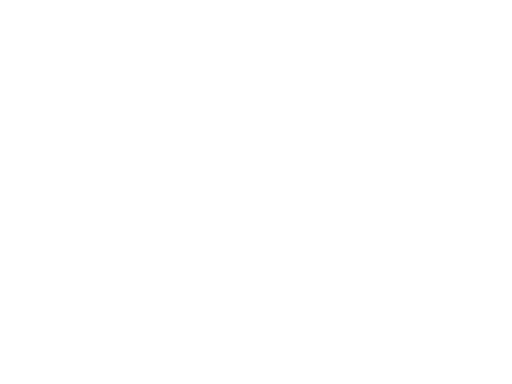

      fun: 58.7811429874468
 hess_inv: array([[6.65798465e-06]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 27
      nit: 6
     njev: 9
   status: 0
  success: True
        x: array([-0.02202637])
[-0.00559208  0.02224998  0.01850732 ... -0.03105658  0.23784354
 -0.04842329]
i:00 mean:0.001875(0.001114) stdev:0.066501(0.000788) Nchanged:0 Nused:3562 Nskipped:0
i:01 mean:0.001188(0.000463) stdev:0.027425(0.000328) Nchanged:60 Nused:3502 Nskipped:60
i:02 mean:-0.000188(0.000357) stdev:0.020916(0.000252) Nchanged:71 Nused:3431 Nskipped:131
i:03 mean:-0.000517(0.000338) stdev:0.019708(0.000239) Nchanged:36 Nused:3395 Nskipped:167
i:04 mean:-0.000536(0.000336) stdev:0.019579(0.000238) Nchanged:5 Nused:3390 Nskipped:172
i:05 mean:-0.000536(0.000336) stdev:0.019579(0.000238) Nchanged:0 Nused:3390 Nskipped:172
mean:-0.000536 (uncertainty:0.000336)


<IPython.core.display.Javascript object>


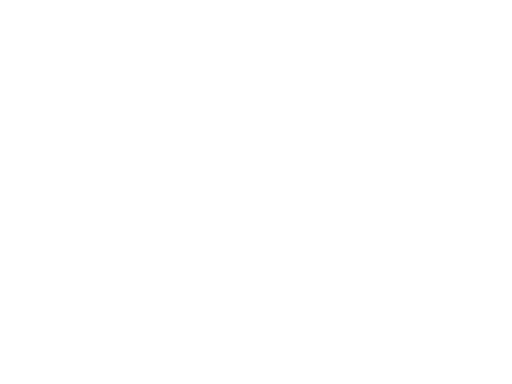

<IPython.core.display.Javascript object>


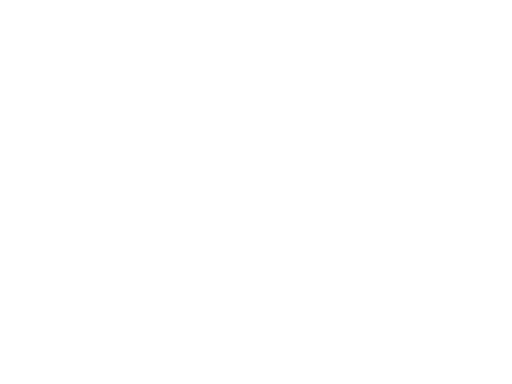

      fun: 51.16998335635279
 hess_inv: array([[4.7680126e-06]])
      jac: array([3.81469727e-06])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 6
     njev: 10
   status: 0
  success: True
        x: array([0.02437413])
[ 0.02140425 -0.01306484  0.01080386 ...  0.00979279  0.03151866
 -0.00941256]
i:00 mean:0.006134(0.000670) stdev:0.047668(0.000474) Nchanged:0 Nused:5055 Nskipped:0
i:01 mean:0.004278(0.000274) stdev:0.019391(0.000194) Nchanged:47 Nused:5008 Nskipped:47
i:02 mean:0.004198(0.000234) stdev:0.016435(0.000165) Nchanged:73 Nused:4935 Nskipped:120
i:03 mean:0.004097(0.000228) stdev:0.015990(0.000161) Nchanged:27 Nused:4908 Nskipped:147
i:04 mean:0.004068(0.000227) stdev:0.015923(0.000161) Nchanged:5 Nused:4903 Nskipped:152
i:05 mean:0.004058(0.000227) stdev:0.015910(0.000161) Nchanged:1 Nused:4902 Nskipped:153
i:06 mean:0.004058(0.000227) stdev:0.015910(0.000161) Nchanged:0 Nused:4902 Nskipped:153
mean:0.004058 (uncertainty:0.000227)


<IPython.core.display.Javascript object>


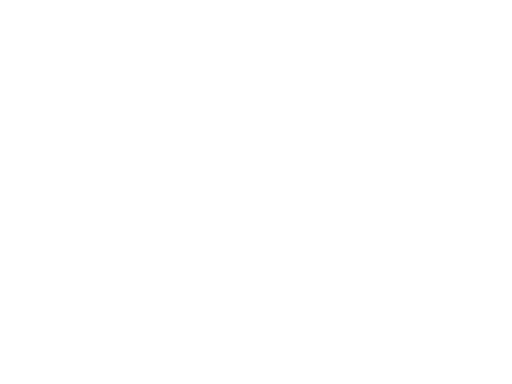

<IPython.core.display.Javascript object>


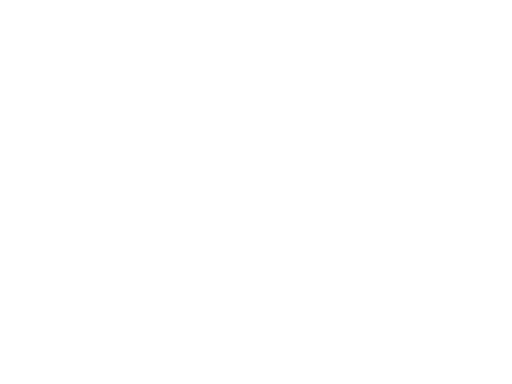

      fun: 94.64039596146989
 hess_inv: array([[4.94025201e-06]])
      jac: array([-9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 7
     njev: 10
   status: 0
  success: True
        x: array([0.03019248])
[0.02815009 0.01276251 0.01198996 ... 0.01079342 0.04511331 0.01385582]
i:00 mean:-0.000575(0.000914) stdev:0.065017(0.000647) Nchanged:0 Nused:5055 Nskipped:0
i:01 mean:0.000920(0.000406) stdev:0.028698(0.000287) Nchanged:52 Nused:5003 Nskipped:52
i:02 mean:0.000893(0.000350) stdev:0.024598(0.000248) Nchanged:72 Nused:4931 Nskipped:124
i:03 mean:0.000815(0.000343) stdev:0.023999(0.000242) Nchanged:25 Nused:4906 Nskipped:149
i:04 mean:0.000815(0.000342) stdev:0.023918(0.000242) Nchanged:4 Nused:4902 Nskipped:153
i:05 mean:0.000829(0.000341) stdev:0.023898(0.000241) Nchanged:1 Nused:4901 Nskipped:154
i:06 mean:0.000829(0.000341) stdev:0.023898(0.000241) Nchanged:0 Nused:4901 Nskipped:154
mean:0.000829 (uncertainty:0.000341)


<IPython.core.display.Javascript object>


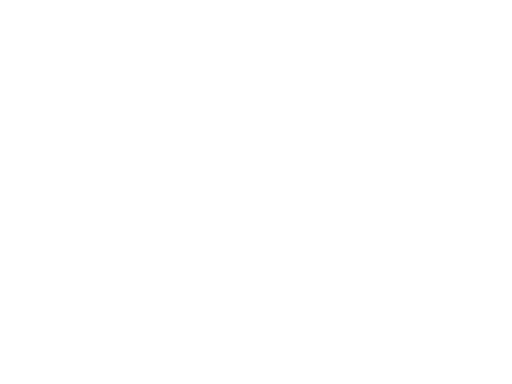

<IPython.core.display.Javascript object>


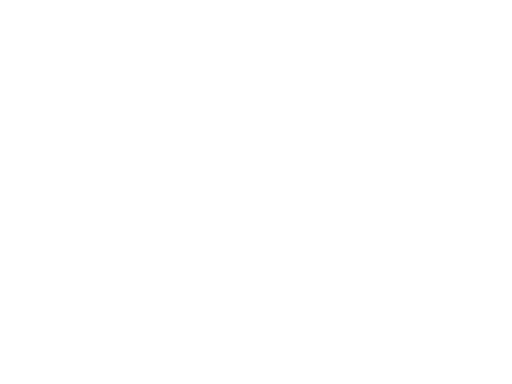

      fun: 83.23059361676405
 hess_inv: array([[4.59951945e-06]])
      jac: array([0.00011158])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 162
      nit: 4
     njev: 50
   status: 2
  success: False
        x: array([-0.00651461])
[-0.00403998 -0.00990209 -0.00590277 ...  0.0274232   0.03635113
  0.01333023]
i:00 mean:0.001662(0.000823) stdev:0.058506(0.000582) Nchanged:0 Nused:5055 Nskipped:0
i:01 mean:0.000796(0.000339) stdev:0.023985(0.000240) Nchanged:58 Nused:4997 Nskipped:58
i:02 mean:0.000224(0.000282) stdev:0.019817(0.000200) Nchanged:71 Nused:4926 Nskipped:129
i:03 mean:0.000289(0.000276) stdev:0.019340(0.000195) Nchanged:25 Nused:4901 Nskipped:154
i:04 mean:0.000253(0.000275) stdev:0.019226(0.000194) Nchanged:7 Nused:4894 Nskipped:161
i:05 mean:0.000242(0.000274) stdev:0.019179(0.000194) Nchanged:3 Nused:4891 Nskipped:164
i:06 mean:0.000242(0.000274) stdev:0.019179(0.000194) Nchanged:0 Nused:4891 Nskipped:164
mean:0.000242 (uncerta

<IPython.core.display.Javascript object>


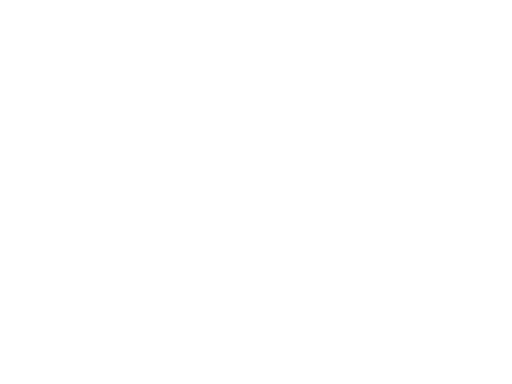

<IPython.core.display.Javascript object>


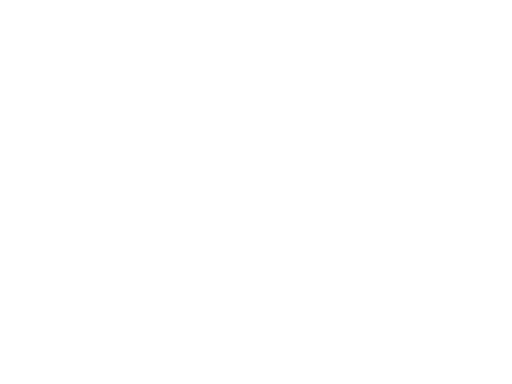

      fun: 68.5003406590555
 hess_inv: array([[2.99719497e-06]])
      jac: array([0.00231171])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 279
      nit: 8
     njev: 89
   status: 2
  success: False
        x: array([0.03081575])
[ 0.08562295 -0.01042905 -0.0138444  ...  0.00634225  0.02320102
 -0.00476171]
i:00 mean:0.002957(0.000388) stdev:0.033632(0.000275) Nchanged:0 Nused:7505 Nskipped:0
i:01 mean:0.001277(0.000229) stdev:0.019729(0.000162) Nchanged:82 Nused:7423 Nskipped:82
i:02 mean:0.001403(0.000214) stdev:0.018313(0.000151) Nchanged:75 Nused:7348 Nskipped:157
i:03 mean:0.001497(0.000211) stdev:0.018028(0.000149) Nchanged:26 Nused:7322 Nskipped:183
i:04 mean:0.001534(0.000210) stdev:0.017957(0.000148) Nchanged:7 Nused:7315 Nskipped:190
i:05 mean:0.001542(0.000210) stdev:0.017948(0.000148) Nchanged:1 Nused:7314 Nskipped:191
i:06 mean:0.001542(0.000210) stdev:0.017948(0.000148) Nchanged:0 Nused:7314 Nskipped:191
mean:0.001542 (uncertain

<IPython.core.display.Javascript object>


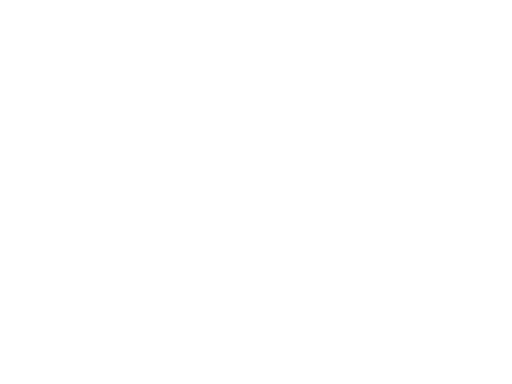

<IPython.core.display.Javascript object>


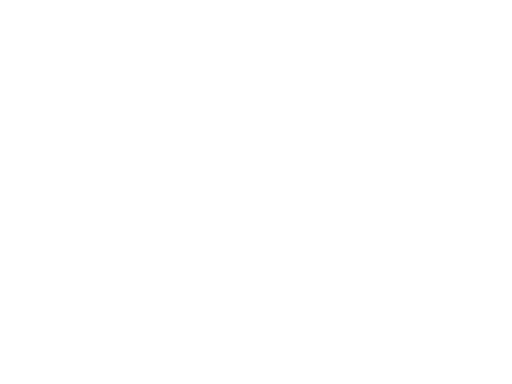

      fun: 159.7108297544231
 hess_inv: array([[3.73478056e-06]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 8
     njev: 12
   status: 0
  success: True
        x: array([0.03278106])
[ 0.13282245 -0.01651962 -0.02324706 ... -0.00598649  0.03446062
 -0.00577117]
i:00 mean:-0.001472(0.000587) stdev:0.050818(0.000415) Nchanged:0 Nused:7505 Nskipped:0
i:01 mean:0.000066(0.000347) stdev:0.029934(0.000246) Nchanged:82 Nused:7423 Nskipped:82
i:02 mean:0.000505(0.000322) stdev:0.027597(0.000228) Nchanged:80 Nused:7343 Nskipped:162
i:03 mean:0.000614(0.000317) stdev:0.027110(0.000224) Nchanged:29 Nused:7314 Nskipped:191
i:04 mean:0.000682(0.000315) stdev:0.026927(0.000223) Nchanged:12 Nused:7302 Nskipped:203
i:05 mean:0.000671(0.000315) stdev:0.026882(0.000222) Nchanged:3 Nused:7299 Nskipped:206
i:06 mean:0.000671(0.000315) stdev:0.026882(0.000222) Nchanged:0 Nused:7299 Nskipped:206
mean:0.000671 (uncertainty:0.000315)


<IPython.core.display.Javascript object>


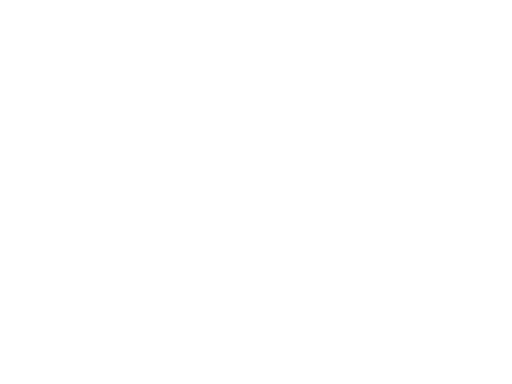

<IPython.core.display.Javascript object>


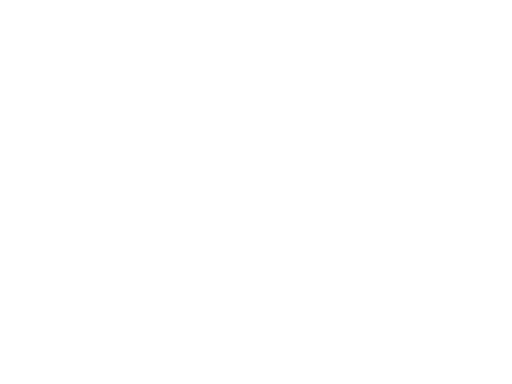

      fun: 125.95067541676508
 hess_inv: array([[2.94916239e-06]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([-0.02050286])
[-0.11706577 -0.01704879 -0.02754    ...  0.00518343  0.005599
 -0.01602167]
i:00 mean:0.001578(0.000544) stdev:0.047087(0.000384) Nchanged:0 Nused:7505 Nskipped:0
i:01 mean:0.001357(0.000272) stdev:0.023446(0.000192) Nchanged:71 Nused:7434 Nskipped:71
i:02 mean:0.000801(0.000242) stdev:0.020701(0.000171) Nchanged:100 Nused:7334 Nskipped:171
i:03 mean:0.000604(0.000236) stdev:0.020147(0.000167) Nchanged:42 Nused:7292 Nskipped:213
i:04 mean:0.000604(0.000234) stdev:0.019986(0.000166) Nchanged:14 Nused:7278 Nskipped:227
i:05 mean:0.000579(0.000234) stdev:0.019952(0.000165) Nchanged:3 Nused:7275 Nskipped:230
i:06 mean:0.000579(0.000234) stdev:0.019952(0.000165) Nchanged:0 Nused:7275 Nskipped:230
mean:0.000579 (uncertainty:0.000234)


<IPython.core.display.Javascript object>


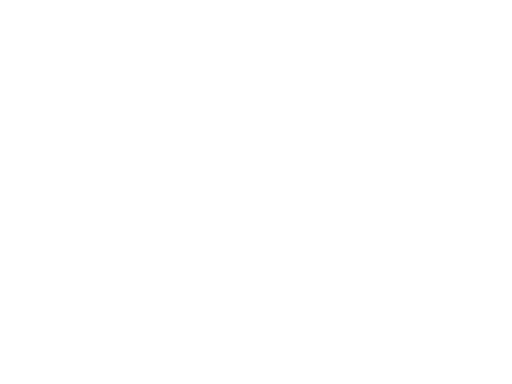

<IPython.core.display.Javascript object>


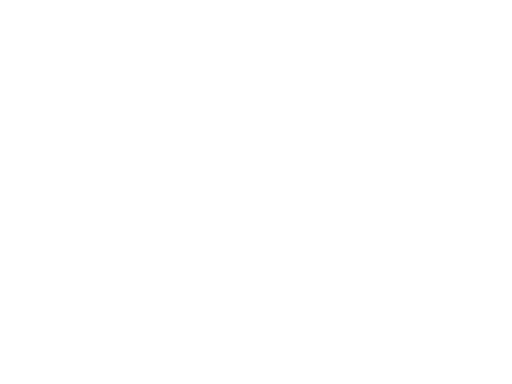

      fun: 112.43110707308921
 hess_inv: array([[2.28732751e-06]])
      jac: array([9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 42
      nit: 8
     njev: 14
   status: 0
  success: True
        x: array([0.03324661])
[ 0.01573105  0.00970109 -0.03495004 ...  0.00898069 -0.02730661
 -0.00980885]
i:00 mean:-0.010144(0.001906) stdev:0.096435(0.001347) Nchanged:0 Nused:2561 Nskipped:0
i:01 mean:-0.012421(0.000792) stdev:0.039761(0.000560) Nchanged:40 Nused:2521 Nskipped:40
i:02 mean:-0.008734(0.000535) stdev:0.026505(0.000378) Nchanged:65 Nused:2456 Nskipped:105
i:03 mean:-0.008005(0.000436) stdev:0.021341(0.000309) Nchanged:64 Nused:2392 Nskipped:169
i:04 mean:-0.007810(0.000397) stdev:0.019224(0.000281) Nchanged:45 Nused:2347 Nskipped:214
i:05 mean:-0.007858(0.000380) stdev:0.018305(0.000269) Nchanged:24 Nused:2323 Nskipped:238
i:06 mean:-0.007979(0.000369) stdev:0.017728(0.000261) Nchanged:17 Nused:2306 Nskipped:255
i:07 mean:-0.008003(0.000365) stde

<IPython.core.display.Javascript object>


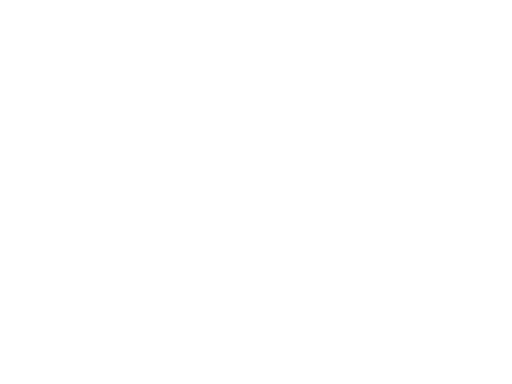

<IPython.core.display.Javascript object>


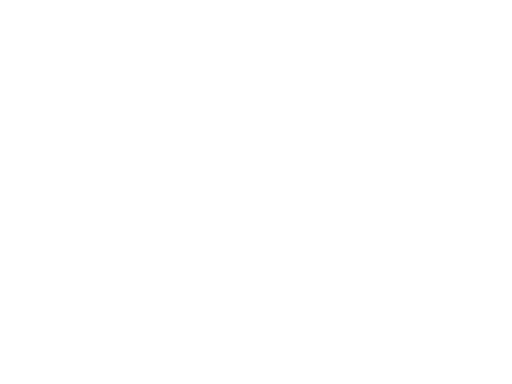

      fun: 47.77858269073818
 hess_inv: array([[9.31966965e-06]])
      jac: array([-4.76837158e-07])
  message: 'Optimization terminated successfully.'
     nfev: 33
      nit: 7
     njev: 11
   status: 0
  success: True
        x: array([0.018489])
[ 0.03567642  0.00567635 -0.04339264 ...  0.02117947 -0.02963281
 -0.00339632]
i:00 mean:-0.002769(0.002650) stdev:0.134092(0.001874) Nchanged:0 Nused:2561 Nskipped:0
i:01 mean:-0.005628(0.001195) stdev:0.059925(0.000845) Nchanged:46 Nused:2515 Nskipped:46
i:02 mean:-0.000820(0.000812) stdev:0.040138(0.000574) Nchanged:69 Nused:2446 Nskipped:115
i:03 mean:0.000079(0.000663) stdev:0.032368(0.000469) Nchanged:64 Nused:2382 Nskipped:179
i:04 mean:0.000458(0.000599) stdev:0.028922(0.000423) Nchanged:48 Nused:2334 Nskipped:227
i:05 mean:0.000301(0.000568) stdev:0.027268(0.000402) Nchanged:28 Nused:2306 Nskipped:255
i:06 mean:0.000262(0.000554) stdev:0.026496(0.000391) Nchanged:15 Nused:2291 Nskipped:270
i:07 mean:0.000262(0.000545) stdev:0.026

<IPython.core.display.Javascript object>


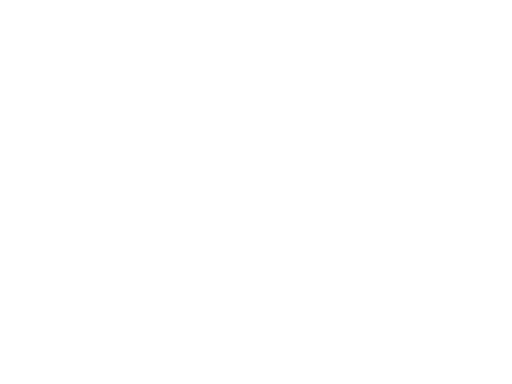

<IPython.core.display.Javascript object>


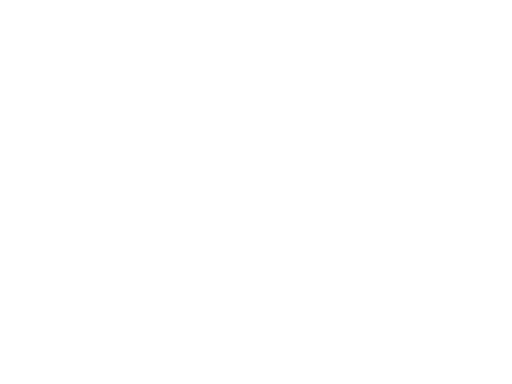

      fun: 41.31875952334522
 hess_inv: array([[8.92603417e-06]])
      jac: array([2.38418579e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 174
      nit: 5
     njev: 54
   status: 2
  success: False
        x: array([-0.00489799])
[ 0.03123208 -0.0112602   0.00195928 ...  0.01718638  0.00956978
 -0.00995495]
i:00 mean:0.003478(0.002509) stdev:0.126966(0.001774) Nchanged:0 Nused:2561 Nskipped:0
i:01 mean:0.011076(0.001039) stdev:0.052025(0.000734) Nchanged:52 Nused:2509 Nskipped:52
i:02 mean:0.005262(0.000615) stdev:0.030303(0.000435) Nchanged:79 Nused:2430 Nskipped:131
i:03 mean:0.002435(0.000470) stdev:0.022868(0.000332) Nchanged:62 Nused:2368 Nskipped:193
i:04 mean:0.001562(0.000424) stdev:0.020474(0.000300) Nchanged:41 Nused:2327 Nskipped:234
i:05 mean:0.001342(0.000412) stdev:0.019829(0.000292) Nchanged:16 Nused:2311 Nskipped:250
i:06 mean:0.001315(0.000410) stdev:0.019720(0.000290) Nchanged:3 Nused:2308 Nskipped:253
i:07 mean:0.0013

<IPython.core.display.Javascript object>


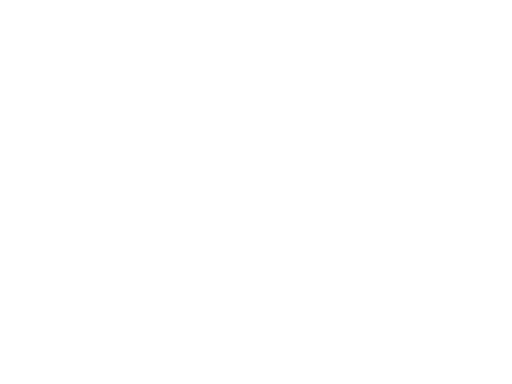

<IPython.core.display.Javascript object>


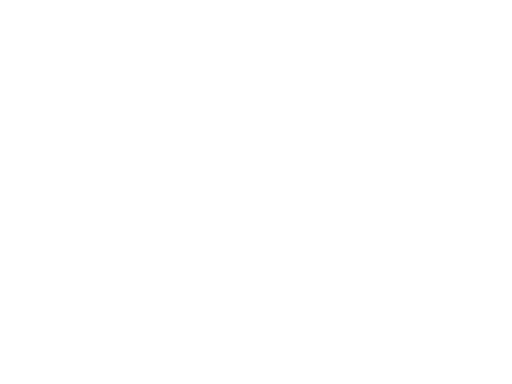

In [603]:
camps = np.arange(1,19)
combos = ['g-i','r-i','i-z']
for camp in camps:
    for combo in combos:
        #compare = np.array([['g-r','k-i']])#,['g-r','k-i'],['r-i','g-k']])
        compare = np.array([['g-r',combo]])#,['g-r','r-i']])#,['r-i','g-k']])
        #compare = np.array([['g-r','k-r'],['g-r','k-i'],['g-r','g-k']])
        bds = [(20.4,27)]#,(-0.01,0.01),(-0.01,0.01),(-0.01,0.01),(-0.01,0.01)]
        zps = np.zeros(84) * np.nan
        cind =  ((data['campaign'].values == camp) & (kbe < .1))
        if len(cind)> 0:
        #cind =  ((data['campaign'].values == 16))
            fitfilt = 'i'
            colours = {}
            colours['obs g-r'] = np.array([(gb - rb)[cind], (gbe + rbe)[cind]])
            colours['obs g-i'] = np.array([(gb - ib)[cind], (gbe + ibe)[cind]])
            colours['obs r-i'] = np.array([(rb - ib)[cind], (rbe + ibe)[cind]])
            colours['obs i-z'] = np.array([(ib - zb)[cind], (ibe + zbe)[cind]])
            #colours['obs g-k'] = np.array([(gb - kb)[cind], (gbe + kbe)[cind]])
            colours['mod g-r'] = col1[good]
            colours['mod g-i'] = col2[good]
            colours['mod r-i'] = col3[good]
            colours['mod i-z'] = col4[good]
            #colours['mod g-k'] = col5[good]
            keys = np.array(list(colours.keys()))
            #print(obs.shape)
            zp0 = 0#25.4
            Ak0 = Ag0 = Ar0 = Ai0 = 0
            k0 = [zp0]#np.array([zp0,Ak0,Ag0,Ar0,Ai0])
            #nll = lambda *args: -colours_like(*args)
            #res = op.minimize(nll, [25.4, 0, 0,0,0], args=(colours, compare, False))

            res = minimize(SLR_fit_multi,k0,args=(c,compare,fitfilt,False))
            print(res)
            K0 = res.x
            c = Cut_data(K0,colours,compare,fitfilt,Plot=False)
            res = minimize(SLR_fit_multi,K0,args=(c,compare,False))
            #res = minimize(SLR_fit_multi,k0,args=(colours,compare,True),bounds=bds)
            if len(res.x) < 2:
                zps = res.x
            else:
                if cind.any():
                    zps = res.x[0]
                else:
                    zps = np.nan
                #print(res.x)

            Plotter(res.x,c,compare,camp,fitfilt,Close=True)
            Plotter(res.x,c,compare,camp,fitfilt,Residuals=True,Close=True)

In [601]:
camp

9

[0.05733578 0.06357453 0.07185837 ... 0.02249223 0.08129021 0.0242975 ]
i:00 mean:0.053481(0.002048) stdev:0.080814(0.001448) Nchanged:0 Nused:1557 Nskipped:0
i:01 mean:0.054999(0.000756) stdev:0.029713(0.000535) Nchanged:12 Nused:1545 Nskipped:12
i:02 mean:0.054636(0.000645) stdev:0.025203(0.000456) Nchanged:19 Nused:1526 Nskipped:31
i:03 mean:0.054583(0.000629) stdev:0.024486(0.000445) Nchanged:9 Nused:1517 Nskipped:40
i:04 mean:0.054682(0.000626) stdev:0.024350(0.000442) Nchanged:2 Nused:1515 Nskipped:42
i:05 mean:0.054682(0.000626) stdev:0.024350(0.000442) Nchanged:0 Nused:1515 Nskipped:42
mean:0.054682 (uncertainty:0.000626)


<IPython.core.display.Javascript object>


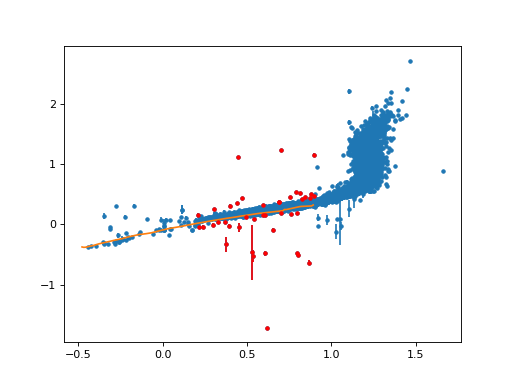

In [223]:
c = Cut_data(K0,colours,compare,Plot=True)

In [234]:
def Cut_data(K,Colours,Compare,Plot=False):
    Params = Parms_dict(K)
    c_cut = copy.deepcopy(Colours)
    for X,Y in Compare:
        #X = 'g-r'
        #Y = 'i-z'
        dist = Dist_tensor(X,Y,Params,Colours,True)
        if len(dist) > 0:

            ob_x, ob_y, locus = Get_lcs(X,Y,Params,Colours)
            ob_x2, ob_y2, locus = Get_lcs(X,Y,Params,Colours)
            ind = np.where((Colours['obs g-r'][0,:] <= .9) & (Colours['obs g-r'][0,:] >= 0.2))[0]

            #if X == 'g-r':
            #    ind = np.where((ob_x[0,:] <= .9) & (ob_x[0,:] >= 0.2) & (ob_y[1,:] < 0.5))[0]
            #elif X == 'r-i':
            #    ind = np.where((ob_x[0,:] <= .6) & (ob_x[0,:] >= 0) & (ob_y[1,:] < 0.5))[0]
            ob_x = ob_x[:,ind]
            ob_y = ob_y[:,ind]


            #bad = []
            #print(type(dist))
            #print('std',np.nanstd(dist.flatten()))
            dist = dist.flatten()
            finiteinds = np.where(np.isfinite(dist))[0]
            #dist[~np.isfinite(dist)] = np.nan
            bad = sigma_mask(dist,error=ob_y[:,1],sigma=3)
            bad = finiteinds[bad]
            #for i in range(len(dist)):
                #print(dist[i],ob_y[1,i])
             #   if abs(dist[i]) > 1:
                    #print(dist,ob_y[0,i])
              #      bad += [i]
              #  if abs(dist[i]) > 10*ob_y[1,i]:

               #     bad += [i]
            if Plot:
                plt.figure()
                plt.errorbar(ob_x2[0,:],ob_y2[0,:],yerr = ob_y2[1,:],fmt='.')
                plt.errorbar(locus[0,:],locus[1,:])
                #plt.errorbar(ob_x[0,bad],ob_y[0,bad],yerr = ob_y[1,bad],fmt='.')
                plt.errorbar(ob_x2[0,ind[bad]],ob_y2[0,ind[bad]],yerr = ob_y2[1,ind[bad]],fmt='r.')
                #plt.xlim(.5,0.9)

            for key in keys:
                if 'obs' in key:
                    #print(dist[bad],6*c_cut[key][1, main_ind[bad]])
                    c_cut[key][:, ind[bad]] = np.nan
                    #print('killed ', key)
            #print(colours[keys[xind][0]][:, main_ind[bad]])
    return c_cut

[ 0.01433369  0.00097853  0.0173841  ... -0.01470957  0.02566387
  0.02346746]
i:00 mean:0.003484(0.002578) stdev:0.101714(0.001823) Nchanged:0 Nused:1557 Nskipped:0
i:01 mean:0.001084(0.000665) stdev:0.026088(0.000470) Nchanged:17 Nused:1540 Nskipped:17
i:02 mean:0.000993(0.000528) stdev:0.020611(0.000374) Nchanged:18 Nused:1522 Nskipped:35
i:03 mean:0.000898(0.000517) stdev:0.020146(0.000366) Nchanged:6 Nused:1516 Nskipped:41
i:04 mean:0.000818(0.000515) stdev:0.020038(0.000364) Nchanged:2 Nused:1514 Nskipped:43
i:05 mean:0.000818(0.000515) stdev:0.020038(0.000364) Nchanged:0 Nused:1514 Nskipped:43
mean:0.000818 (uncertainty:0.000515)


<IPython.core.display.Javascript object>


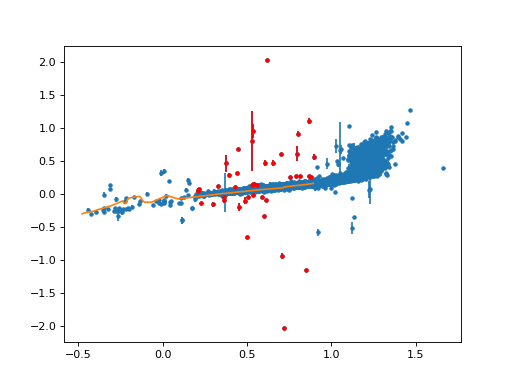

In [235]:
c = Cut_data(K0,colours,compare,Plot=True)

<IPython.core.display.Javascript object>


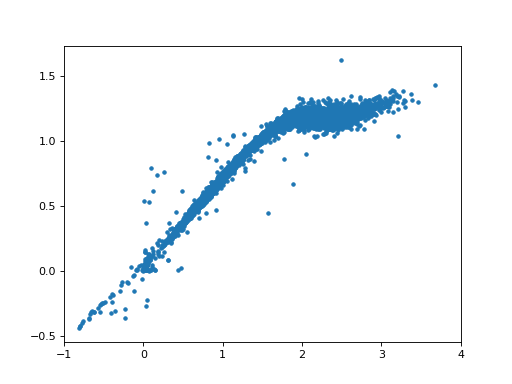

(-1, 4)

In [315]:
plt.figure()
plt.plot(colours['obs g-i'].flatten(),colours['obs g-r'].flatten(),'.')
#plt.plot(c['obs g-r'].flatten(),c['obs i-z'].flatten(),'.')
plt.xlim(-1,4)

In [347]:
from scipy.interpolate import interp1d

In [360]:
tonry1 = np.loadtxt('ps1_r-i_g-r.csv',delimiter=',')
tonry2 = np.loadtxt('ps1_r-i_i-z.csv',delimiter=',')

In [486]:
spline = interp1d(tonry[:,0],tonry[:,1])
spline2 = interp1d(tonry2[:,0],tonry2[:,1],bounds_error=False,fill_value='extrapolate')

In [487]:
rex = np.arange(min(tonry[:,0]),max(tonry[:,0]),0.001)
rey = spline(rex)
rey2 = spline2(rex,)


In [632]:
saver = np.array((rex,rey,rey2))

In [634]:
np.savetxt('Tonry_splines.txt',saver)

<IPython.core.display.Javascript object>


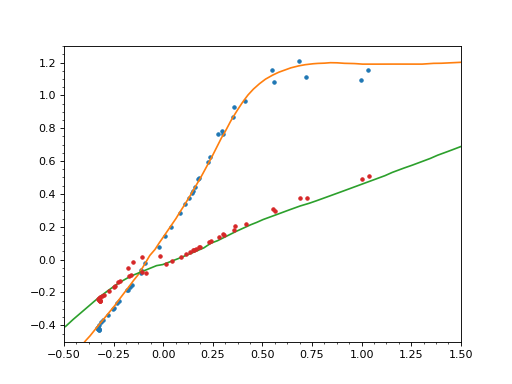

In [488]:
plt.figure()
plt.plot(colours['mod r-i']+.05,colours['mod g-r']+.05,'.')
plt.plot(rex,rey,'-')
plt.plot(rex,rey2,'-')
plt.plot(colours['mod r-i']+0.055,colours['mod i-z']+.05,'.')
plt.ylim(-.5,1.3)
plt.xlim(-.5,1.5)
plt.minorticks_on()

In [571]:
def Calculate_distance(data,trend):
    x = np.zeros((data.shape[1],trend.shape[1])) + data[0,:,np.newaxis]
    x -= trend[0,np.newaxis,:]
    y = np.zeros((data.shape[1],trend.shape[1])) + data[1,:,np.newaxis]
    y -= trend[1,np.newaxis,:]

    dist = np.sqrt(x**2 + y**2)

    minind = np.nanargmin(abs(dist),axis=1)
    #proj_err = Dot_prod_error(ob_x,ob_y,locus[:,minind])
    mindist = np.nanmin(abs(dist),axis=1)
    sign = (data[1,:] - trend[1,minind])
    sign = sign / abs(sign)

    resid = mindist * sign
    return resid
    
def Fit_spline(offset, data, trend):
    dat = data.copy()
    dat[0,:] += offset[0]
    dat[1,:] += offset[1] 
    
    resid = Residuals(dat,trend)
    residual = np.nansum(abs(resid))

    return residual

def Fit_spline_multi(offset, data, trend):
    res = 0
    for i in range(len(data)):
        dat = data[i].copy()
        dat[0,:] += offset[0]
        if i ==0:
            dat[1,:] +=  offset[1] - offset[0]
        else:
            dat[1,:] += offset[2]

        resid = Residuals(dat,trend[i])
        residual = np.nansum(abs(resid))
        res += residual

    return res

In [636]:
datiz = np.array((colours['mod r-i'],colours['mod i-z'])) - 0.01
datgr = np.array((colours['mod r-i'],colours['mod g-r']))
modgr = np.array((rex,rey))
modiz = np.array((rex,rey2)) + 0.01

1.1159854373689582
      fun: 0.42301967488798026
 hess_inv: array([[ 9.27288771e-05, -4.63629131e-05],
       [-4.63629131e-05,  7.86951314e-05]])
      jac: array([2.48476863e-06, 4.79444861e-06])
  message: 'Optimization terminated successfully.'
     nfev: 88
      nit: 16
     njev: 22
   status: 0
  success: True
        x: array([0.07854226, 0.10432243])


<IPython.core.display.Javascript object>


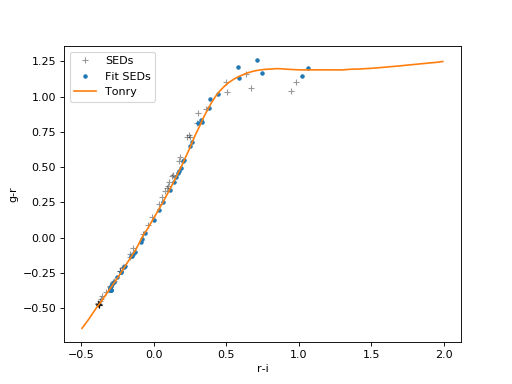

Text(0.5, 0, 'r-i')

In [637]:
print(np.nansum(abs(Residuals(datgr,modgr))))

x0 = [0,0]
#bds = ((-.08,.08),(-.08,.08))
res = minimize(Fit_spline,x0,args=(datgr,modgr))
print(res)
plt.figure()
plt.plot(datgr[0,:],datgr[1,:],'k+',label='SEDs',alpha=0.4)
plt.plot(datgr[0,:]+res.x[0],datgr[1,:]+res.x[1],'.',label='Fit SEDs')
plt.plot(modgr[0,:],modgr[1,:],'-',label='Tonry')
plt.legend()

plt.ylabel('g-r')
plt.xlabel('r-i')

In [573]:
res.x[1]+res.x[0]

0.18286469042983222

0.6523218422857884
      fun: 0.7892992219374803
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.43938877e+00, -3.66373598e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 24
      nit: 5
   status: 0
  success: True
        x: array([0.07854226, 0.06138583])


<IPython.core.display.Javascript object>


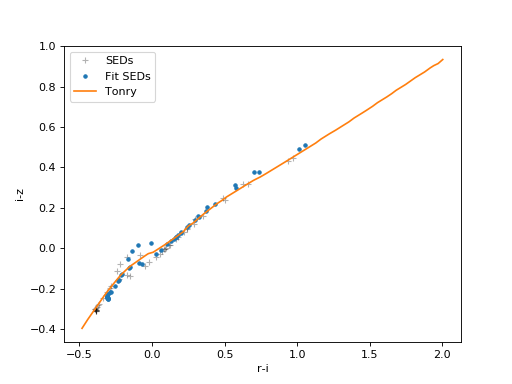

Text(0.5, 0, 'r-i')

In [638]:
print(np.nansum(abs(Residuals(datiz,modiz))))
x0 = [0.05,0.05]
bds = ((res.x[0],res.x[0]),(-1,1))
re = minimize(Fit_spline,x0,args=(datiz,modiz),bounds=bds)
print(re)
plt.figure()
plt.plot(datiz[0,:],datiz[1,:],'k+',label='SEDs',alpha=.3)
plt.plot(datiz[0,:]+re.x[0],datiz[1,:]+re.x[1],'.',label='Fit SEDs')
#plt.plot(datiz[0,:],datiz[1,:],'k.')
plt.plot(modiz[0,:],modiz[1,:],'-',label='Tonry')
plt.legend()

plt.ylabel('i-z')
plt.xlabel('r-i')

In [565]:
x0 = [0,0,0]
bds = ((res.x[0],res.x[0]),(-1,1))
re = minimize(Fit_spline_multi,x0,args=([datiz,datgr],[modiz,modgr]),method = 'Nelder-Mead')
re

 final_simplex: (array([[0.06740835, 0.12246913, 0.08684191],
       [0.06739807, 0.12247278, 0.08681449],
       [0.06740505, 0.12252132, 0.08683653],
       [0.06736432, 0.12240953, 0.0868358 ]]), array([1.17254882, 1.17255419, 1.1725597 , 1.17256465]))
           fun: 1.1725488228105936
       message: 'Optimization terminated successfully.'
          nfev: 195
           nit: 110
        status: 0
       success: True
             x: array([0.06740835, 0.12246913, 0.08684191])

<IPython.core.display.Javascript object>


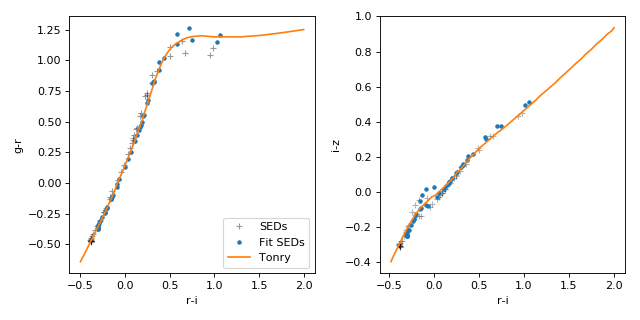

In [642]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(datgr[0,:],datgr[1,:],'k+',label='SEDs',alpha=0.4)
plt.plot(datgr[0,:]+res.x[0],datgr[1,:]+res.x[1],'.',label='Fit SEDs')
plt.plot(modgr[0,:],modgr[1,:],'-',label='Tonry')
plt.legend()

plt.ylabel('g-r')
plt.xlabel('r-i')

plt.subplot(1,2,2)
plt.plot(datiz[0,:],datiz[1,:],'k+',label='SEDs',alpha=.3)
plt.plot(datiz[0,:]+re.x[0],datiz[1,:]+re.x[1],'.',label='Fit SEDs')
#plt.plot(datiz[0,:],datiz[1,:],'k.')
plt.plot(modiz[0,:],modiz[1,:],'-',label='Tonry')

plt.ylabel('i-z')
plt.xlabel('r-i')
plt.tight_layout()
plt.savefig('CK_vs_Tonry.pdf')

In [515]:
thingo = datiz.copy()
thingo[0,:] += res.x[0]
thingo[1,:] += res.x[1]
np.nansum(abs(Residuals(thingo,modiz)))

2.2114235891974907

<IPython.core.display.Javascript object>


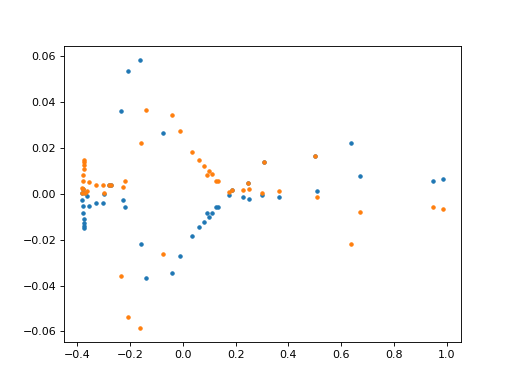

In [492]:
plt.figure()
plt.plot(datiz[0,:],Residuals(datiz,modiz),'.')
plt.plot(datiz[0,:],mindist * sign,'.')

In [481]:
dat = datiz
mod = modiz
x = np.zeros((dat.shape[1],mod.shape[1])) + dat[0,:,np.newaxis]
x -= mod[0,np.newaxis,:]
y = np.zeros((dat.shape[1],mod.shape[1])) + dat[1,:,np.newaxis]
y -= mod[1,np.newaxis,:]

dist = np.sqrt(x**2 + y**2)

minind = np.nanargmin(abs(dist),axis=1)
#proj_err = Dot_prod_error(ob_x,ob_y,locus[:,minind])
mindist = np.nanmin(abs(dist),axis=1)
sign = (dat[1,:] - mod[1,minind])
sign = sign / abs(sign)

resid = mindist * sign

In [482]:
minind = np.nanargmin(abs(dist),axis=1)
#proj_err = Dot_prod_error(ob_x,ob_y,locus[:,minind])
mindist = np.nanmin(abs(dist),axis=1)
sign = (datgr[1,:] - modgr[1,minind])
sign = sign / abs(sign)

In [438]:
sign

array([-1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,
       -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [439]:
mindist * sign

array([-0.00409359, -0.00321317, -0.0019    ,  0.00032503,  0.00218852,
        0.00457406,  0.00695066,  0.00912131,  0.01165947,  0.01173781,
        0.0091287 ,  0.00957124,  0.01067865,  0.00916899,  0.01005036,
        0.01591472,  0.02244322,  0.01378755,  0.0139722 ,  0.01801993,
        0.01951612,  0.02224866,  0.02425799,  0.02560401,  0.02727178,
        0.0312678 ,  0.02813855,  0.02544396,  0.01191359, -0.04497579,
       -0.10828348, -0.15260404, -0.0897577 ,  0.0118254 ,  0.0093633 ,
        0.021861  ,  0.03277732,  0.03792354,  0.01585535, -0.00443384,
        0.01434751,  0.01231401,  0.01282594,  0.00755641,  0.00762809,
        0.00419113,  0.02943949,  0.04819258,  0.04566787])

In [ ]:
plt.figure()

# what do we expect from dust?

In [607]:
from astropy.coordinates import SkyCoord
from dustmaps.bayestar import BayestarQuery
import astropy.units as u

In [608]:
data

ID  campaign   Kpmag     RAJ2000   DecJ2000  \
0       240252225        11  12.865  263.793562 -29.997039   
1       240256177        11  15.209  264.202808 -29.983788   
2       231458371        11  13.843  257.353395 -29.979526   
3       231461068        11  15.238  257.460891 -29.969176   
4       235586661        11  17.005  259.600918 -29.968737   
...           ...       ...     ...         ...        ...   
163354  202064761         0  18.400  101.395000  28.836400   
163355  202066738         0  14.600  101.028900  28.868520   
163356  202085664         0  15.900  101.397410  28.888150   
163357  202067114         0  14.400  100.956330  28.919800   
163358  202090563         0  14.600  101.356080  28.961580   

                     objID  ps_score      raMean    decMean  raMeanErr  ...  \
0        72002637935683847  0.859804  263.793568 -29.997021    0.00462  ...   
1        72012642029659459  0.835958  264.203038 -29.984112    0.00844  ...   
2        72022573533964867  0.899167  257.353383 -29.979531    0.00494  ...   
3        72032574608577262  0.905000  257.460843 -29.969208    0.00238  ...   
4        72032596009007860  0.931750  259.600903 -29.968721    0.00347  ...   
...                    ...       ...         ...        ...        ...  ...   
163354  142601013953554418  0.992101  101.395334  28.836538    0.00303  ...   
163355  142641010288792817  0.995208  101.028904  28.868524    0.00457  ...   
163356  142661013974826192  0.966280  101.397416  28.887992    0.00289  ...   
163357  142701009562734305  0.983958  100.956319  28.919805    0.01055  ...   
163358  142751013560434379  0.998750  101.355993  28.961456    0.00415  ...   

        yQfPerfect  primaryDetection  bestDetection  Module  Channel  Output  \
0         0.998782                 1              1       6       16       4   
1         0.999765                 1              1       6       16       4   
2         0.999408                 1              1      16       53       1   
3         0.999134                 1              1      16       53       1   
4         0.999068                 1              1      16       55       3   
...            ...               ...            ...     ...      ...     ...   
163354    0.999513                 1              1      10       32       4   
163355    0.998875                 1              1      10       32       4   
163356    0.999583                 1              1      10       32       4   
163357    0.999572                 1              1      10       32       4   
163358    0.999650                 1              1      10       32       4   

                 PDC          PDCe           SAP          SAPe  
0       25301.869945  11528.469253  24838.423107  12004.054269  
1        5728.921506    674.671919   5672.403149    799.376657  
2       49534.755974  23655.657632  49734.239736  23516.686200  
3       45788.342836  18583.963914  45029.506741  18875.511008  
4        9201.518296   1589.902547   9017.230503   1558.882332  
...              ...           ...           ...           ...  
163354   2345.906732    321.487615   2286.911499    496.439072  
163355  18537.366596   6989.196082  18224.444214   5037.861100  
163356  12984.416433   4694.344015  12648.535980   4951.679903  
163357  22587.121204   8626.266543  22305.766510   6859.859068  
163358  45043.348605  14841.564461  41094.378448  11734.877707  

[142705 rows x 54 columns]

In [609]:
coords = SkyCoord(data['RAJ2000'].values*u.deg, data['DecJ2000'].values*u.deg,distance=500.*u.pc, frame='icrs')
bayestar = BayestarQuery(max_samples=1)

red = bayestar(coords, mode='median')

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 38.539 s
  pix_info:   0.867 s
   samples:  10.890 s
      best:  13.681 s
       nan:   0.390 s
      sort:  12.326 s
       idx:   0.385 s


In [610]:
data['dust'] = red

In [611]:
data

ID  campaign   Kpmag     RAJ2000   DecJ2000  \
0       240252225        11  12.865  263.793562 -29.997039   
1       240256177        11  15.209  264.202808 -29.983788   
2       231458371        11  13.843  257.353395 -29.979526   
3       231461068        11  15.238  257.460891 -29.969176   
4       235586661        11  17.005  259.600918 -29.968737   
...           ...       ...     ...         ...        ...   
163354  202064761         0  18.400  101.395000  28.836400   
163355  202066738         0  14.600  101.028900  28.868520   
163356  202085664         0  15.900  101.397410  28.888150   
163357  202067114         0  14.400  100.956330  28.919800   
163358  202090563         0  14.600  101.356080  28.961580   

                     objID  ps_score      raMean    decMean  raMeanErr  ...  \
0        72002637935683847  0.859804  263.793568 -29.997021    0.00462  ...   
1        72012642029659459  0.835958  264.203038 -29.984112    0.00844  ...   
2        72022573533964867  0.899167  257.353383 -29.979531    0.00494  ...   
3        72032574608577262  0.905000  257.460843 -29.969208    0.00238  ...   
4        72032596009007860  0.931750  259.600903 -29.968721    0.00347  ...   
...                    ...       ...         ...        ...        ...  ...   
163354  142601013953554418  0.992101  101.395334  28.836538    0.00303  ...   
163355  142641010288792817  0.995208  101.028904  28.868524    0.00457  ...   
163356  142661013974826192  0.966280  101.397416  28.887992    0.00289  ...   
163357  142701009562734305  0.983958  100.956319  28.919805    0.01055  ...   
163358  142751013560434379  0.998750  101.355993  28.961456    0.00415  ...   

        primaryDetection  bestDetection  Module  Channel  Output  \
0                      1              1       6       16       4   
1                      1              1       6       16       4   
2                      1              1      16       53       1   
3                      1              1      16       53       1   
4                      1              1      16       55       3   
...                  ...            ...     ...      ...     ...   
163354                 1              1      10       32       4   
163355                 1              1      10       32       4   
163356                 1              1      10       32       4   
163357                 1              1      10       32       4   
163358                 1              1      10       32       4   

                 PDC          PDCe           SAP          SAPe      dust  
0       25301.869945  11528.469253  24838.423107  12004.054269  0.088764  
1        5728.921506    674.671919   5672.403149    799.376657  0.279588  
2       49534.755974  23655.657632  49734.239736  23516.686200  0.140000  
3       45788.342836  18583.963914  45029.506741  18875.511008  0.360000  
4        9201.518296   1589.902547   9017.230503   1558.882332  0.410000  
...              ...           ...           ...           ...       ...  
163354   2345.906732    321.487615   2286.911499    496.439072  0.050000  
163355  18537.366596   6989.196082  18224.444214   5037.861100  0.049588  
163356  12984.416433   4694.344015  12648.535980   4951.679903  0.050000  
163357  22587.121204   8626.266543  22305.766510   6859.859068  0.049588  
163358  45043.348605  14841.564461  41094.378448  11734.877707  0.040000  

[142705 rows x 55 columns]

In [614]:
test = data.iloc[data['campaign'].values == 1]

<IPython.core.display.Javascript object>


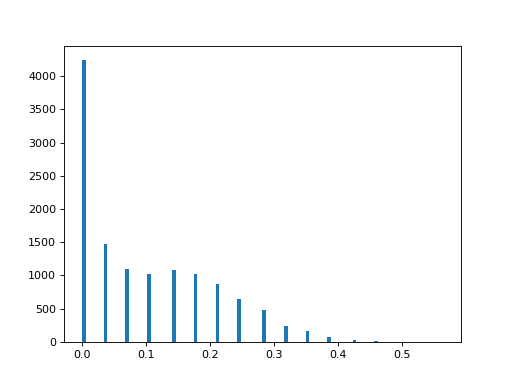

(array([4.241e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.474e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.093e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.024e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.087e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.017e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 8.680e+02, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 6.390e+02, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 4.840e+02, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.330e+02, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.570e+02, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 7.800e+01, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 3.200e+01, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

In [625]:
plt.figure()
plt.hist(test.dust.values*3.518,bins=100)

In [624]:
np.mean(test.dust*1.971)

0.05518863217226994

In [620]:
np.median(test.dust)

0.02

In [621]:
np.std(test.dust)

0.029116066

In [313]:
extinction = np.zeros((4,len(red))) + red[np.newaxis,:]

In [314]:
ex = extinction * np.array([3.518, 2.617, 1.971, 1.549])[:,np.newaxis]

In [292]:
plt.plot

array([0.02617, 0.02617, 0.     , ..., 0.23553, 0.07851, 0.15702],
      dtype=float32)

In [293]:
thing * 3.518

array([0.03518   , 0.03518   , 0.        , ..., 0.31661996, 0.10553999,
       0.21107998], dtype=float32)

In [ ]:
red * 